In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from scipy.stats.mstats import winsorize

from sklearn.datasets import fetch_openml
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import datasets, metrics
from sklearn.manifold import TSNE
import umap

import time
import warnings
warnings.filterwarnings('ignore')

### For this project I will be looking at Baseball Databank data on baseball players, teams, and games from 1871 to 2015.  This can be found on Kaggle at https://www.kaggle.com/open-source-sports/baseball-databank

I am going to focus mainly on pitching, my goal to be able to find a good pitcher to put into a fantasy lineup. If I have time I will explore batting and fielding as well. Eventually I will get to all of these files, but not for this particular project. 

In [2]:
# Import csv files. 
batting = pd.read_csv('Batting.csv')
salary = pd.read_csv('Salaries.csv')
fielding = pd.read_csv('Fielding.csv')
pitching = pd.read_csv('Pitching.csv')

### I will start by writing some functions I'll be using throughout this project

In [3]:
# Boxplot and histogram functions both take all columns from a df,
# excluding objects and plot the variables as a boxplot and histogram
def boxplot(df, figsize, num_columns):
    lst = list(df.select_dtypes(exclude='object'))
    fig = plt.figure(figsize=(figsize))
    for i, col in enumerate(lst):
    
        plt.subplot(len(lst), num_columns, i+1)
        plt.boxplot(df[col])
        plt.title('boxplot of {}'.format(col))
        plt.tight_layout()
        
def histogram(df, figsize, num_columns):
    lst = list(df.select_dtypes(exclude='object'))
    fig = plt.figure(figsize=(figsize))
    for i, col in enumerate(lst):
    
        plt.subplot(len(lst), num_columns, i+1)
        plt.hist(df[col])
        plt.title('histogram of {}'.format(col))
        plt.tight_layout()
        
def scatter(df, target_variable, figsize, num_columns):
    lst = list(df.select_dtypes(exclude=['object', 'category']))
    fig = plt.figure(figsize=(figsize))
    for i, col in enumerate(lst):
    
        plt.subplot(len(lst), num_columns, i+1)
        sns.scatterplot(x=df[col], y=df[target_variable])
        plt.title('Scatter of {} in relation to {}'.format(col,target_variable))
        plt.tight_layout()


In [4]:
#Making life easier to get the df name
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [5]:
# function to be able to check for outliers and a function
# to winsorize said outliers 
def check_outliers(df):
    lst = list(df.select_dtypes(exclude=['object', 'category']))
    length = len(df)
    for col in lst:
        q75, q25 = np.percentile(df[col], [75 ,25])
        iqr = q75 - q25

        min_val = q25 - (iqr*1.5)
        max_val = q75 + (iqr*1.5)
        print("Number of outliers and percentage of it in {} : {} and %{}".format(col, len((np.where((df[col] > max_val) |
                                                                                            (df[col] < min_val))[0])), len((np.where((df[col] > max_val) |
                                                                                                                                         (df[col] < min_val))[0]))*100/length)) 
        print('percent of outliers low')
        print(len(np.where(df[col] < min_val)[0]) /length)
        print('Percent of outliers high')
        print(len(np.where(df[col] > max_val)[0]) /length)
        print(90 * '-')
        
def winsorize_outliers(df):
    lst = list(df.select_dtypes(exclude=['object', 'category']))
    length = len(df)
    for col in lst:
        q75, q25 = np.percentile(df[col], [75, 25])
        iqr = q75 - q25

        min_val = q25 - (iqr*1.5)
        max_val = q75 + (iqr*1.5)

        df[col] = winsorize(df[col], (len(np.where(df[col] < min_val)[0]) / length,
                                      len(np.where(df[col] > max_val)[
                                          0]) / length
                                      )
                            )

### This gem I found on towardsdatascience.com so I can't take credit, but it is a really clever solution to imputing data using KNN. So far this is the most reasonable way I can think to deal with missing data.

In [6]:
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy.stats import hmean
from scipy.spatial.distance import cdist
from scipy import stats
import numbers


def weighted_hamming(data):
    """ Compute weighted hamming distance on categorical variables. For one variable, it is equal to 1 if
        the values between point A and point B are different, else it is equal the relative frequency of the
        distribution of the value across the variable. For multiple variables, the harmonic mean is computed
        up to a constant factor.
        @params:
            - data = a pandas data frame of categorical variables
        @returns:
            - distance_matrix = a distance matrix with pairwise distance for all attributes
    """
    categories_dist = []
    
    for category in data:
        X = pd.get_dummies(data[category])
        X_mean = X * X.mean()
        X_dot = X_mean.dot(X.transpose())
        X_np = np.asarray(X_dot.replace(0,1,inplace=False))
        categories_dist.append(X_np)
    categories_dist = np.array(categories_dist)
    distances = hmean(categories_dist, axis=0)
    return distances


def distance_matrix(data, numeric_distance = "euclidean", categorical_distance = "jaccard"):
    """ Compute the pairwise distance attribute by attribute in order to account for different variables type:
        - Continuous
        - Categorical
        For ordinal values, provide a numerical representation taking the order into account.
        Categorical variables are transformed into a set of binary ones.
        If both continuous and categorical distance are provided, a Gower-like distance is computed and the numeric
        variables are all normalized in the process.
        If there are missing values, the mean is computed for numerical attributes and the mode for categorical ones.
        
        Note: If weighted-hamming distance is chosen, the computation time increases a lot since it is not coded in C 
        like other distance metrics provided by scipy.
        @params:
            - data                  = pandas dataframe to compute distances on.
            - numeric_distances     = the metric to apply to continuous attributes.
                                      "euclidean" and "cityblock" available.
                                      Default = "euclidean"
            - categorical_distances = the metric to apply to binary attributes.
                                      "jaccard", "hamming", "weighted-hamming" and "euclidean"
                                      available. Default = "jaccard"
        @returns:
            - the distance matrix
    """
    possible_continuous_distances = ["euclidean", "cityblock"]
    possible_binary_distances = ["euclidean", "jaccard", "hamming", "weighted-hamming"]
    number_of_variables = data.shape[1]
    number_of_observations = data.shape[0]

    # Get the type of each attribute (Numeric or categorical)
    is_numeric = [all(isinstance(n, numbers.Number) for n in data.iloc[:, i]) for i, x in enumerate(data)]
    is_all_numeric = sum(is_numeric) == len(is_numeric)
    is_all_categorical = sum(is_numeric) == 0
    is_mixed_type = not is_all_categorical and not is_all_numeric

    # Check the content of the distances parameter
    if numeric_distance not in possible_continuous_distances:
        print("The continuous distance " + numeric_distance + " is not supported.")
        return None
    elif categorical_distance not in possible_binary_distances:
        print("The binary distance " + categorical_distance + " is not supported.")
        return None

    # Separate the data frame into categorical and numeric attributes and normalize numeric data
    if is_mixed_type:
        number_of_numeric_var = sum(is_numeric)
        number_of_categorical_var = number_of_variables - number_of_numeric_var
        data_numeric = data.iloc[:, is_numeric]
        data_numeric = (data_numeric - data_numeric.mean()) / (data_numeric.max() - data_numeric.min())
        data_categorical = data.iloc[:, [not x for x in is_numeric]]

    # Replace missing values with column mean for numeric values and mode for categorical ones. With the mode, it
    # triggers a warning: "SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame"
    # but the value are properly replaced
    if is_mixed_type:
        data_numeric.fillna(data_numeric.mean(), inplace=True)
        for x in data_categorical:
            data_categorical[x].fillna(data_categorical[x].mode()[0], inplace=True)
    elif is_all_numeric:
        data.fillna(data.mean(), inplace=True)
    else:
        for x in data:
            data[x].fillna(data[x].mode()[0], inplace=True)

    # "Dummifies" categorical variables in place
    if not is_all_numeric and not (categorical_distance == 'hamming' or categorical_distance == 'weighted-hamming'):
        if is_mixed_type:
            data_categorical = pd.get_dummies(data_categorical)
        else:
            data = pd.get_dummies(data)
    elif not is_all_numeric and categorical_distance == 'hamming':
        if is_mixed_type:
            data_categorical = pd.DataFrame([pd.factorize(data_categorical[x])[0] for x in data_categorical]).transpose()
        else:
            data = pd.DataFrame([pd.factorize(data[x])[0] for x in data]).transpose()

    if is_all_numeric:
        result_matrix = cdist(data, data, metric=numeric_distance)
    elif is_all_categorical:
        if categorical_distance == "weighted-hamming":
            result_matrix = weighted_hamming(data)
        else:
            result_matrix = cdist(data, data, metric=categorical_distance)
    else:
        result_numeric = cdist(data_numeric, data_numeric, metric=numeric_distance)
        if categorical_distance == "weighted-hamming":
            result_categorical = weighted_hamming(data_categorical)
        else:
            result_categorical = cdist(data_categorical, data_categorical, metric=categorical_distance)
        result_matrix = np.array([[1.0*(result_numeric[i, j] * number_of_numeric_var + result_categorical[i, j] *
                               number_of_categorical_var) / number_of_variables for j in range(number_of_observations)] for i in range(number_of_observations)])

    # Fill the diagonal with NaN values
    np.fill_diagonal(result_matrix, np.nan)

    return pd.DataFrame(result_matrix)


def knn_impute(target, attributes, k_neighbors, aggregation_method="mean", numeric_distance="euclidean",
               categorical_distance="jaccard", missing_neighbors_threshold = 0.5):
    """ Replace the missing values within the target variable based on its k nearest neighbors identified with the
        attributes variables. If more than 50% of its neighbors are also missing values, the value is not modified and
        remains missing. If there is a problem in the parameters provided, returns None.
        If to many neighbors also have missing values, leave the missing value of interest unchanged.
        @params:
            - target                        = a vector of n values with missing values that you want to impute. The length has
                                              to be at least n = 3.
            - attributes                    = a data frame of attributes with n rows to match the target variable
            - k_neighbors                   = the number of neighbors to look at to impute the missing values. It has to be a
                                              value between 1 and n.
            - aggregation_method            = how to aggregate the values from the nearest neighbors (mean, median, mode)
                                              Default = "mean"
            - numeric_distances             = the metric to apply to continuous attributes.
                                              "euclidean" and "cityblock" available.
                                              Default = "euclidean"
            - categorical_distances         = the metric to apply to binary attributes.
                                              "jaccard", "hamming", "weighted-hamming" and "euclidean"
                                              available. Default = "jaccard"
            - missing_neighbors_threshold   = minimum of neighbors among the k ones that are not also missing to infer
                                              the correct value. Default = 0.5
        @returns:
            target_completed        = the vector of target values with missing value replaced. If there is a problem
                                      in the parameters, return None
    """

    # Get useful variables
    possible_aggregation_method = ["mean", "median", "mode"]
    number_observations = len(target)
    is_target_numeric = all(isinstance(n, numbers.Number) for n in target)

    # Check for possible errors
    if number_observations < 3:
        print("Not enough observations.")
        return None
    if attributes.shape[0] != number_observations:
        print("The number of observations in the attributes variable is not matching the target variable length.")
        return None
    if k_neighbors > number_observations or k_neighbors < 1:
        print("The range of the number of neighbors is incorrect.")
        return None
    if aggregation_method not in possible_aggregation_method:
        print("The aggregation method is incorrect.")
        return None
    if not is_target_numeric and aggregation_method != "mode":
        print("The only method allowed for categorical target variable is the mode.")
        return None

    # Make sure the data are in the right format
    target = pd.DataFrame(target)
    attributes = pd.DataFrame(attributes)

    # Get the distance matrix and check whether no error was triggered when computing it
    distances = distance_matrix(attributes, numeric_distance, categorical_distance)
    if distances is None:
        return None

    # Get the closest points and compute the correct aggregation method
    for i, value in enumerate(target.iloc[:, 0]):
        if pd.isnull(value):
            order = distances.iloc[i,:].values.argsort()[:k_neighbors]
            closest_to_target = target.iloc[order, :]
            missing_neighbors = [x for x  in closest_to_target.isnull().iloc[:, 0]]
            # Compute the right aggregation method if at least more than 50% of the closest neighbors are not missing
            if sum(missing_neighbors) >= missing_neighbors_threshold * k_neighbors:
                continue
            elif aggregation_method == "mean":
                target.iloc[i] = np.ma.mean(np.ma.masked_array(closest_to_target,np.isnan(closest_to_target)))
            elif aggregation_method == "median":
                target.iloc[i] = np.ma.median(np.ma.masked_array(closest_to_target,np.isnan(closest_to_target)))
            else:
                target.iloc[i] = stats.mode(closest_to_target, nan_policy='omit')[0][0]

    return target

### I'm not cutting this function my mentor sent me. It's great for reducing memory usage for integer variables, but not for float.

In [7]:
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

In [8]:
# Looking at length and head of each df
all_df = [salary, batting, fielding, pitching]
for df in all_df:
    print(get_df_name(df).upper(), '\n')
    print('length of {}:'.format(get_df_name(df)), len(df))
    print('=' * 40)
    display(df.head())


SALARY 

length of salary: 25575


yearID teamID lgID   playerID  salary
0    1985    ATL   NL  barkele01  870000
1    1985    ATL   NL  bedrost01  550000
2    1985    ATL   NL  benedbr01  545000
3    1985    ATL   NL   campri01  633333
4    1985    ATL   NL  ceronri01  625000

BATTING 

length of batting: 101332


playerID  yearID  stint teamID lgID   G     AB     R     H    2B  ...  \
0  abercda01    1871      1    TRO  NaN   1    4.0   0.0   0.0   0.0  ...   
1   addybo01    1871      1    RC1  NaN  25  118.0  30.0  32.0   6.0  ...   
2  allisar01    1871      1    CL1  NaN  29  137.0  28.0  40.0   4.0  ...   
3  allisdo01    1871      1    WS3  NaN  27  133.0  28.0  44.0  10.0  ...   
4  ansonca01    1871      1    RC1  NaN  25  120.0  29.0  39.0  11.0  ...   

    RBI   SB   CS   BB   SO  IBB  HBP  SH  SF  GIDP  
0   0.0  0.0  0.0  0.0  0.0  NaN  NaN NaN NaN   NaN  
1  13.0  8.0  1.0  4.0  0.0  NaN  NaN NaN NaN   NaN  
2  19.0  3.0  1.0  2.0  5.0  NaN  NaN NaN NaN   NaN  
3  27.0  1.0  1.0  0.0  2.0  NaN  NaN NaN NaN   NaN  
4  16.0  6.0  2.0  2.0  1.0  NaN  NaN NaN NaN   NaN  

[5 rows x 22 columns]

FIELDING 

length of fielding: 170526


playerID  yearID  stint teamID lgID POS   G  GS  InnOuts    PO     A  \
0  abercda01    1871      1    TRO  NaN  SS   1 NaN      NaN   1.0   3.0   
1   addybo01    1871      1    RC1  NaN  2B  22 NaN      NaN  67.0  72.0   
2   addybo01    1871      1    RC1  NaN  SS   3 NaN      NaN   8.0  14.0   
3  allisar01    1871      1    CL1  NaN  2B   2 NaN      NaN   1.0   4.0   
4  allisar01    1871      1    CL1  NaN  OF  29 NaN      NaN  51.0   3.0   

      E   DP  PB  WP  SB  CS  ZR  
0   2.0  0.0 NaN NaN NaN NaN NaN  
1  42.0  5.0 NaN NaN NaN NaN NaN  
2   7.0  0.0 NaN NaN NaN NaN NaN  
3   0.0  0.0 NaN NaN NaN NaN NaN  
4   7.0  1.0 NaN NaN NaN NaN NaN

PITCHING 

length of pitching: 44139


playerID  yearID  stint teamID lgID   W   L   G  GS  CG  ...  IBB  WP  \
0  bechtge01    1871      1    PH1  NaN   1   2   3   3   2  ...  NaN NaN   
1  brainas01    1871      1    WS3  NaN  12  15  30  30  30  ...  NaN NaN   
2  fergubo01    1871      1    NY2  NaN   0   0   1   0   0  ...  NaN NaN   
3  fishech01    1871      1    RC1  NaN   4  16  24  24  22  ...  NaN NaN   
4  fleetfr01    1871      1    NY2  NaN   0   1   1   1   1  ...  NaN NaN   

   HBP  BK  BFP  GF    R  SH  SF  GIDP  
0  NaN   0  NaN NaN   42 NaN NaN   NaN  
1  NaN   0  NaN NaN  292 NaN NaN   NaN  
2  NaN   0  NaN NaN    9 NaN NaN   NaN  
3  NaN   0  NaN NaN  257 NaN NaN   NaN  
4  NaN   0  NaN NaN   21 NaN NaN   NaN  

[5 rows x 30 columns]

In [9]:
# I'm looking to check salary in comparison to stats so I'll 
# trim my other dataframes to include only dates after 1985
# to match my salary dataframe.
batting = batting.loc[batting.yearID >= 1985]
fielding = fielding.loc[fielding.yearID >= 1985]
pitching = pitching.loc[pitching.yearID >= 1985]
salary = salary.loc[salary.yearID >= 1985]

# checking head and length again
all_df = [salary, batting, fielding, pitching]
for df in all_df:
    print(get_df_name(df).upper(), '\n')
    print('length of {}:'.format(get_df_name(df)), len(df))
    print('=' * 40)
    display(df.head())

SALARY 

length of salary: 25575


yearID teamID lgID   playerID  salary
0    1985    ATL   NL  barkele01  870000
1    1985    ATL   NL  bedrost01  550000
2    1985    ATL   NL  benedbr01  545000
3    1985    ATL   NL   campri01  633333
4    1985    ATL   NL  ceronri01  625000

BATTING 

length of batting: 39095


playerID  yearID  stint teamID lgID   G     AB     R     H   2B  ...  \
62237   aasedo01    1985      1    BAL   AL  54    NaN   NaN   NaN  NaN  ...   
62238  abregjo01    1985      1    CHN   NL   6    9.0   0.0   0.0  0.0  ...   
62239  ackerji01    1985      1    TOR   AL  61    NaN   NaN   NaN  NaN  ...   
62240  adamsri02    1985      1    SFN   NL  54  121.0  12.0  23.0  3.0  ...   
62241  agostju01    1985      1    CHA   AL  54    0.0   0.0   0.0  0.0  ...   

        RBI   SB   CS   BB    SO  IBB  HBP   SH   SF  GIDP  
62237   NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN   NaN  
62238   1.0  0.0  0.0  0.0   2.0  0.0  0.0  0.0  0.0   0.0  
62239   NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN   NaN  
62240  10.0  1.0  1.0  5.0  23.0  3.0  1.0  3.0  0.0   2.0  
62241   0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0   0.0  

[5 rows x 22 columns]

FIELDING 

length of fielding: 71491


playerID  yearID  stint teamID lgID POS   G    GS  InnOuts    PO  \
99035   aasedo01    1985      1    BAL   AL   P  54   0.0    264.0   8.0   
99036  abregjo01    1985      1    CHN   NL   P   6   5.0     72.0   1.0   
99037  ackerji01    1985      1    TOR   AL   P  61   0.0    259.0  10.0   
99038  adamsri02    1985      1    SFN   NL  2B   6   3.0     84.0   9.0   
99039  adamsri02    1985      1    SFN   NL  3B  16  10.0    337.0   2.0   

          A    E   DP  PB  WP  SB  CS  ZR  
99035  10.0  0.0  0.0 NaN NaN NaN NaN NaN  
99036   6.0  1.0  0.0 NaN NaN NaN NaN NaN  
99037  16.0  0.0  1.0 NaN NaN NaN NaN NaN  
99038  13.0  1.0  1.0 NaN NaN NaN NaN NaN  
99039  31.0  1.0  3.0 NaN NaN NaN NaN NaN

PITCHING 

length of pitching: 19159


playerID  yearID  stint teamID lgID   W  L   G  GS  CG  ...  IBB   WP  \
24980   aasedo01    1985      1    BAL   AL  10  6  54   0   0  ...  7.0  0.0   
24981  abregjo01    1985      1    CHN   NL   1  1   6   5   0  ...  1.0  0.0   
24982  ackerji01    1985      1    TOR   AL   7  2  61   0   0  ...  1.0  2.0   
24983  agostju01    1985      1    CHA   AL   4  3  54   0   0  ...  1.0  0.0   
24984  aguilri01    1985      1    NYN   NL  10  7  21  19   2  ...  2.0  5.0   

       HBP  BK    BFP    GF   R  SH  SF  GIDP  
24980  1.0   1  366.0  43.0  44 NaN NaN   NaN  
24981  0.0   0  109.0   0.0  18 NaN NaN   NaN  
24982  3.0   0  370.0  26.0  35 NaN NaN   NaN  
24983  3.0   0  246.0  21.0  27 NaN NaN   NaN  
24984  2.0   2  507.0   1.0  49 NaN NaN   NaN  

[5 rows x 30 columns]

In [10]:
for df in all_df:
    print(get_df_name(df).upper())
    print('='*40)
    print(df.isnull().sum().sort_values(ascending=False), '\n')
    print(len(df), '\n')
    

SALARY
salary      0
playerID    0
lgID        0
teamID      0
yearID      0
dtype: int64 

25575 

BATTING
GIDP        3113
RBI         3113
AB          3113
R           3113
H           3113
2B          3113
SF          3113
HR          3113
3B          3113
SB          3113
CS          3113
BB          3113
SO          3113
IBB         3113
HBP         3113
SH          3113
G              0
lgID           0
teamID         0
stint          0
yearID         0
playerID       0
dtype: int64 

39095 

FIELDING
ZR          69908
WP          69908
CS          68073
SB          68073
PB          68073
GS          41154
InnOuts     14690
A           12115
PO          12115
E           12115
DP          12115
G               0
POS             0
lgID            0
teamID          0
stint           0
yearID          0
playerID        0
dtype: int64 

71491 

PITCHING
GIDP        18414
SH           7920
SF           7920
BAOpp         640
ERA            19
HBP             1
IPouts          1
lgID

In [11]:
#nans lets me see which rows are null easily for a better look
nans = lambda df: df[df.isnull().any(axis=1)] 

display(nans(batting.loc[batting.lgID == 'AL']))

playerID  yearID  stint teamID lgID   G  AB   R   H  2B  ...  RBI  SB  \
62237   aasedo01    1985      1    BAL   AL  54 NaN NaN NaN NaN  ...  NaN NaN   
62239  ackerji01    1985      1    TOR   AL  61 NaN NaN NaN NaN  ...  NaN NaN   
62245  alexado01    1985      1    TOR   AL  36 NaN NaN NaN NaN  ...  NaN NaN   
62248  allenne01    1985      2    NYA   AL  17 NaN NaN NaN NaN  ...  NaN NaN   
62254  armstmi01    1985      1    NYA   AL   9 NaN NaN NaN NaN  ...  NaN NaN   
...          ...     ...    ...    ...  ...  ..  ..  ..  ..  ..  ...  ...  ..   
79190  wengedo01    1999      1    KCA   AL  11 NaN NaN NaN NaN  ...  NaN NaN   
79192  wheelda01    1999      1    TBA   AL   6 NaN NaN NaN NaN  ...  NaN NaN   
79213  willito02    1999      1    SEA   AL  13 NaN NaN NaN NaN  ...  NaN NaN   
79226  wolcobo01    1999      1    BOS   AL   4 NaN NaN NaN NaN  ...  NaN NaN   
79237  yarnaed01    1999      1    NYA   AL   5 NaN NaN NaN NaN  ...  NaN NaN   

       CS  BB  SO  IBB  HBP  SH  SF  GIDP  
62237 NaN NaN NaN  NaN  NaN NaN NaN   NaN  
62239 NaN NaN NaN  NaN  NaN NaN NaN   NaN  
62245 NaN NaN NaN  NaN  NaN NaN NaN   NaN  
62248 NaN NaN NaN  NaN  NaN NaN NaN   NaN  
62254 NaN NaN NaN  NaN  NaN NaN NaN   NaN  
...    ..  ..  ..  ...  ...  ..  ..   ...  
79190 NaN NaN NaN  NaN  NaN NaN NaN   NaN  
79192 NaN NaN NaN  NaN  NaN NaN NaN   NaN  
79213 NaN NaN NaN  NaN  NaN NaN NaN   NaN  
79226 NaN NaN NaN  NaN  NaN NaN NaN   NaN  
79237 NaN NaN NaN  NaN  NaN NaN NaN   NaN  

[3113 rows x 22 columns]

### I will drop nulls for batting. It looks like those are probably all American League pitchers, and pitchers aren't hired for their hitting ability.

In [12]:
batting.dropna(inplace=True)

In [13]:
batting.isnull().sum()

playerID    0
yearID      0
stint       0
teamID      0
lgID        0
G           0
AB          0
R           0
H           0
2B          0
3B          0
HR          0
RBI         0
SB          0
CS          0
BB          0
SO          0
IBB         0
HBP         0
SH          0
SF          0
GIDP        0
dtype: int64

In [14]:
# looking at outliers
check_outliers(batting)

Number of outliers and percentage of it in yearID : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in stint : 2771 and %7.701072758601523
percent of outliers low
0.0
Percent of outliers high
0.07701072758601522
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in G : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in AB : 2092 and %5.8140181201711965
percent of outliers low
0.0
Percent of outliers high
0.058140181201711966
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in R : 3434 and %9.543660719248512
percent of outliers low

In [15]:
# winsorizing outliers 
winsorize_outliers(batting)

In [16]:
# check to make sure the function took
check_outliers(batting)

Number of outliers and percentage of it in yearID : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in stint : 2771 and %7.701072758601523
percent of outliers low
0.0
Percent of outliers high
0.07701072758601522
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in G : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in AB : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in R : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------

In [17]:
# One snuck in so fixing it manually
batting.stint = winsorize(batting.stint, (0, 0.0771))

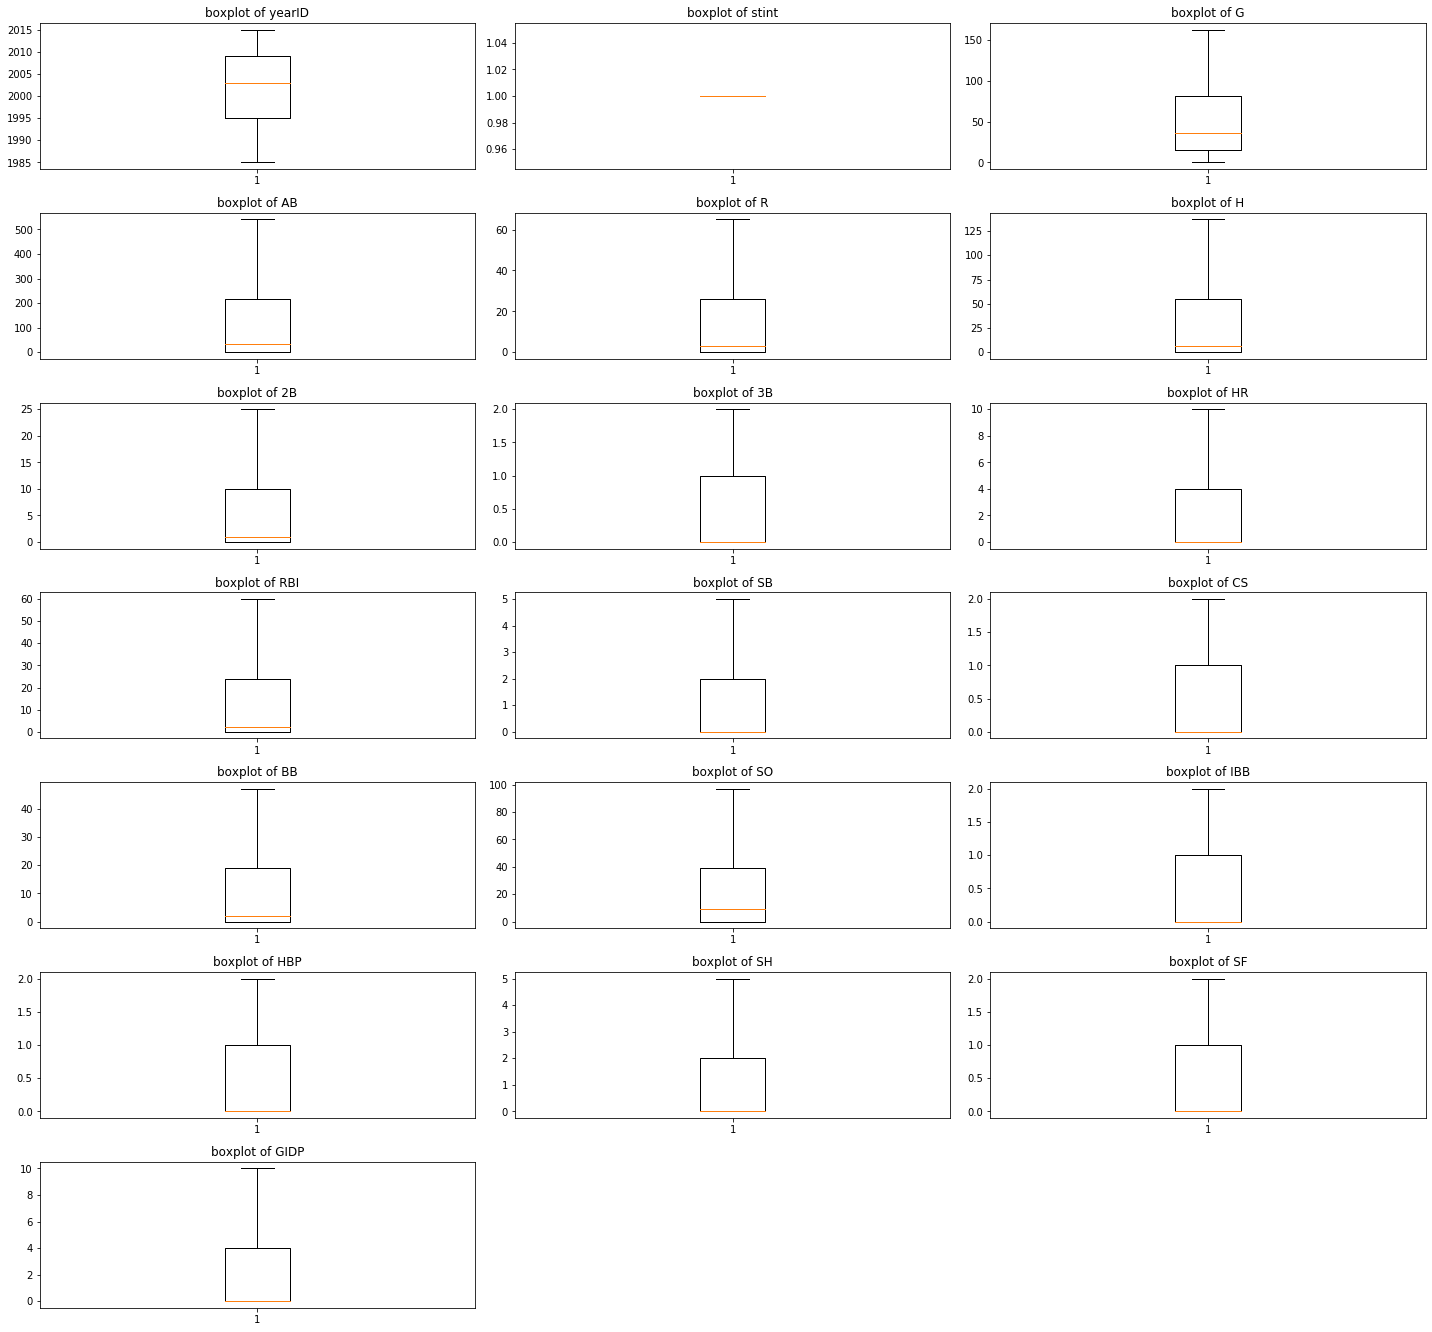

In [18]:
boxplot(batting, (20,50), 3)

In [19]:
# stint only has the one value. I'll drop it
batting.drop(['stint'], axis=1, inplace=True)

### Batting is taken care of as far as nulls and outliers go

# Pitching

## Nulls for pitching

In [20]:
display(nans(pitching))
pitching.isnull().sum()
## how to deal with these nulls now

playerID  yearID  stint teamID lgID   W   L   G  GS  CG  ...  IBB  \
24980   aasedo01    1985      1    BAL   AL  10   6  54   0   0  ...  7.0   
24981  abregjo01    1985      1    CHN   NL   1   1   6   5   0  ...  1.0   
24982  ackerji01    1985      1    TOR   AL   7   2  61   0   0  ...  1.0   
24983  agostju01    1985      1    CHA   AL   4   3  54   0   0  ...  1.0   
24984  aguilri01    1985      1    NYN   NL  10   7  21  19   2  ...  2.0   
...          ...     ...    ...    ...  ...  ..  ..  ..  ..  ..  ...  ...   
44134  youngch03    2015      1    KCA   AL  11   6  34  18   0  ...  0.0   
44135  zieglbr01    2015      1    ARI   NL   0   3  66   0   0  ...  3.0   
44136  zimmejo02    2015      1    WAS   NL  13  10  33  33   0  ...  3.0   
44137   zitoba01    2015      1    OAK   AL   0   0   3   2   0  ...  0.0   
44138   zychto01    2015      1    SEA   AL   0   0  13   1   0  ...  0.0   

        WP  HBP  BK    BFP    GF   R   SH   SF  GIDP  
24980  0.0  1.0   1  366.0  43.0  44  NaN  NaN   NaN  
24981  0.0  0.0   0  109.0   0.0  18  NaN  NaN   NaN  
24982  2.0  3.0   0  370.0  26.0  35  NaN  NaN   NaN  
24983  0.0  3.0   0  246.0  21.0  27  NaN  NaN   NaN  
24984  5.0  2.0   2  507.0   1.0  49  NaN  NaN   NaN  
...    ...  ...  ..    ...   ...  ..  ...  ...   ...  
44134  5.0  0.0   0  500.0   3.0  44  4.0  2.0   NaN  
44135  2.0  1.0   0  263.0  46.0  17  1.0  0.0   NaN  
44136  2.0  8.0   1  831.0   0.0  89  8.0  2.0   NaN  
44137  0.0  0.0   0   37.0   1.0   8  0.0  0.0   NaN  
44138  1.0  2.0   0   76.0   4.0   6  0.0  0.0   NaN  

[18417 rows x 30 columns]

playerID        0
yearID          0
stint           0
teamID          0
lgID            0
W               0
L               0
G               0
GS              0
CG              0
SHO             0
SV              0
IPouts          1
H               0
ER              0
HR              0
BB              0
SO              0
BAOpp         640
ERA            19
IBB             0
WP              0
HBP             1
BK              0
BFP             0
GF              0
R               0
SH           7920
SF           7920
GIDP        18414
dtype: int64

In [21]:
pitching.describe()

yearID         stint             W             L             G  \
count  19159.000000  19159.000000  19159.000000  19159.000000  19159.000000   
mean    2001.424866      1.083929      3.703795      3.703795     26.160029   
std        8.741779      0.289085      4.452438      3.852186     20.419301   
min     1985.000000      1.000000      0.000000      0.000000      1.000000   
25%     1994.000000      1.000000      0.000000      1.000000      9.000000   
50%     2002.000000      1.000000      2.000000      2.000000     22.000000   
75%     2009.000000      1.000000      5.000000      6.000000     35.000000   
max     2015.000000      4.000000     27.000000     21.000000     94.000000   

                 GS            CG           SHO            SV        IPouts  \
count  19159.000000  19159.000000  19159.000000  19159.000000  19158.000000   
mean       7.409677      0.450545      0.145989      1.865703    198.586961   
std       11.134290      1.419866      0.529960      6.575536    190.971385   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000     48.000000   
50%        0.000000      0.000000      0.000000      0.000000    140.000000   
75%       12.000000      0.000000      0.000000      0.000000    268.000000   
max       40.000000     20.000000     10.000000     62.000000    856.000000   

       ...           IBB            WP           HBP            BK  \
count  ...  19159.000000  19159.000000  19158.000000  19159.000000   
mean   ...      2.012631      2.391826      2.247312      0.356229   
std    ...      2.324798      2.771923      2.703938      0.872069   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      1.000000      2.000000      1.000000      0.000000   
75%    ...      3.000000      4.000000      3.000000      0.000000   
max    ...     18.000000     26.000000     21.000000     16.000000   

                BFP            GF             R            SH            SF  \
count  19159.000000  19159.000000  19159.000000  11239.000000  11239.000000   
mean     284.753223      6.959131     33.840910      2.207759      1.908088   
std      267.955396     11.596099     31.342603      2.751917      2.143002   
min        1.000000      0.000000      0.000000      0.000000      0.000000   
25%       74.000000      0.000000     10.000000      0.000000      0.000000   
50%      205.000000      2.000000     23.000000      1.000000      1.000000   
75%      385.000000      9.000000     48.000000      3.000000      3.000000   
max     1231.000000     79.000000    160.000000     21.000000     14.000000   

             GIDP  
count  745.000000  
mean     4.844295  
std      5.524863  
min      0.000000  
25%      1.000000  
50%      3.000000  
75%      7.000000  
max     36.000000  

[8 rows x 27 columns]

In [22]:
# find k value for knn imputation
def get_k(df):
    k = round(np.sqrt((len(df)*0.75)))
    return k
print(get_k(pitching))
print(pitching.info())
k_pitching = get_k(pitching)
print(k_pitching)

120.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 19159 entries, 24980 to 44138
Data columns (total 30 columns):
playerID    19159 non-null object
yearID      19159 non-null int64
stint       19159 non-null int64
teamID      19159 non-null object
lgID        19159 non-null object
W           19159 non-null int64
L           19159 non-null int64
G           19159 non-null int64
GS          19159 non-null int64
CG          19159 non-null int64
SHO         19159 non-null int64
SV          19159 non-null int64
IPouts      19158 non-null float64
H           19159 non-null int64
ER          19159 non-null int64
HR          19159 non-null int64
BB          19159 non-null int64
SO          19159 non-null int64
BAOpp       18519 non-null float64
ERA         19140 non-null float64
IBB         19159 non-null float64
WP          19159 non-null float64
HBP         19158 non-null float64
BK          19159 non-null int64
BFP         19159 non-null float64
GF          19159 non-null float64
R   

In [23]:
print(pitching.GIDP.notnull().sum()/len(pitching))
print(pitching.GIDP.isnull().sum()/len(pitching))
# GIDP stands for ground into double play. Given the fact that there is less than 5% non-null values.
# I am going to drop this variable. Especially because it doesn't make sense to turn this
# into a boolean
pitching.drop(['GIDP'], axis=1, inplace=True)

0.03888511926509734
0.9611148807349027


In [24]:
# I will drop all categorical variables like teamID, playerID, and lgId.
# They have no bearing on what I'm trying to accomplish

impute_list = ['BAOpp', 'IPouts', 'HBP', 'ERA', 'SH', 'SF']

for col in impute_list:
    pitching[col] = knn_impute(target=pitching[col], attributes=pitching.drop(['teamID', 'playerID', 'lgID', col], 1),
                                    aggregation_method="median", k_neighbors=120, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=1)

In [25]:
print(pitching.isnull().sum())

playerID     0
yearID       0
stint        0
teamID       0
lgID         0
W            0
L            0
G            0
GS           0
CG           0
SHO          0
SV           0
IPouts       0
H            0
ER           0
HR           0
BB           0
SO           0
BAOpp        0
ERA          0
IBB          0
WP           0
HBP          0
BK           0
BFP          0
GF           0
R            0
SH          85
SF          85
dtype: int64


In [26]:
# Just 85 null values left in SH and SF
impute_list2 = ['SH', 'SF']

for col in impute_list2:
    pitching[col] = knn_impute(target=pitching[col], attributes=pitching.drop(['teamID', 'playerID', 'lgID', col], 1),
                                    aggregation_method="median", k_neighbors=120, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.9)

In [27]:
print(pitching.isnull().sum())
print(pitching.info())

playerID    0
yearID      0
stint       0
teamID      0
lgID        0
W           0
L           0
G           0
GS          0
CG          0
SHO         0
SV          0
IPouts      0
H           0
ER          0
HR          0
BB          0
SO          0
BAOpp       0
ERA         0
IBB         0
WP          0
HBP         0
BK          0
BFP         0
GF          0
R           0
SH          0
SF          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 19159 entries, 24980 to 44138
Data columns (total 29 columns):
playerID    19159 non-null object
yearID      19159 non-null int64
stint       19159 non-null int64
teamID      19159 non-null object
lgID        19159 non-null object
W           19159 non-null int64
L           19159 non-null int64
G           19159 non-null int64
GS          19159 non-null int64
CG          19159 non-null int64
SHO         19159 non-null int64
SV          19159 non-null int64
IPouts      19159 non-null float64
H           19159 non-null int64
E

In [28]:
# these variables are interesting. If I winsorize them, they all only have one value. All except for stint
print(pitching[['stint', 'BK', 'CG', 'SHO', 'SV']].head())
for col in ['stint', 'BK', 'CG', 'SHO', 'SV']:
    print('Unique Values\n{}: {}\n'.format(col,pitching[col].unique()))

       stint  BK  CG  SHO  SV
24980      1   1   0    0  14
24981      1   0   0    0   0
24982      1   0   0    0  10
24983      1   0   0    0   1
24984      1   2   2    0   0
Unique Values
stint: [1 2 3 4]

Unique Values
BK: [ 1  0  2  3  4  5  7  6  9  8 11 12 10 16 13 15]

Unique Values
CG: [ 0  2  6 10  4  1  5  9 15 13  8  3 11  7 16 14 17 12 20 18]

Unique Values
SHO: [ 0  1  2  4  3  8  5 10  6  7]

Unique Values
SV: [14  0 10  1  2  3  4  8  9  7  6 12 25 11 17 13 26  5 31 29 32 19 16 27
 37 41 33 23 34 20 24 21 22 35 46 36 40 18 28 45 39 30 42 15 44 38 48 43
 57 47 51 53 50 52 55 49 62]



In [29]:
check_unique = ['stint', 'BK', 'CG', 'SHO', 'SV']
for col in check_unique:
    print('value counts for {}: \n{}\n {}'.format(col, pitching[col].value_counts(), pitching[col].value_counts(normalize=True)))
# BK = Balk, CG = Complete Game, SHO = complete game shutout, SV = Saves

value counts for stint: 
1    17612
2     1489
3       55
4        3
Name: stint, dtype: int64
 1    0.919255
2    0.077718
3    0.002871
4    0.000157
Name: stint, dtype: float64
value counts for BK: 
0     14848
1      2938
2       814
3       306
4       117
5        64
6        26
7        20
8        10
10        4
9         4
11        3
12        2
15        1
13        1
16        1
Name: BK, dtype: int64
 0     0.774988
1     0.153348
2     0.042487
3     0.015972
4     0.006107
5     0.003340
6     0.001357
7     0.001044
8     0.000522
10    0.000209
9     0.000209
11    0.000157
12    0.000104
15    0.000052
13    0.000052
16    0.000052
Name: BK, dtype: float64
value counts for CG: 
0     15906
1      1462
2       669
3       369
4       242
5       149
6       103
7        80
8        50
9        42
10       28
11       14
12       12
13       10
14        9
15        9
16        2
20        1
18        1
17        1
Name: CG, dtype: int64
 0     0.830210
1     0.076309
2

### I am going to turn these variables into categorical. continuous doesn't really make sense. I will bin the values depending on the variable.

In [30]:
pitching['BK'] = pitching['BK'].replace([x for x in pitching['BK'] if x > 1], 2)
print(pitching.BK.value_counts())
print(pitching.BK.value_counts(normalize=True))


pitching['CG'] = pitching['CG'].replace([1,2],1)
pitching['CG'] = pitching['CG'].replace([x for x in pitching['CG'] if x >= 3],2)
pitching['SV'] = pitching['SV'].replace([2,3],1)

print(pitching['CG'].unique())


0    14848
1     2938
2     1373
Name: BK, dtype: int64
0    0.774988
1    0.153348
2    0.071663
Name: BK, dtype: float64
[0 1 2]


In [31]:
pitching['stint'] = pitching['stint'].replace(4,3)
pitching['SHO'] = pitching['SHO'].replace([x for x in pitching['SHO'] if x > 0],1)
pitching['SV'] = pitching['SV'].replace([x for x in pitching['SV'] if x > 3],2)
for col in check_unique:
    print(pitching[col].unique())
    print(pitching[col].value_counts(normalize=True))
#not even one full % in value 3 for stint. I'll just bin those values with 2


[1 2 3]
1    0.919255
2    0.077718
3    0.003027
Name: stint, dtype: float64
[1 0 2]
0    0.774988
1    0.153348
2    0.071663
Name: BK, dtype: float64
[0 1 2]
0    0.830210
1    0.111227
2    0.058563
Name: CG, dtype: float64
[0 1]
0    0.90297
1    0.09703
Name: SHO, dtype: float64
[2 0 1]
0    0.771074
1    0.138838
2    0.090088
Name: SV, dtype: float64


In [32]:
print(pitching.stint.value_counts(normalize=True))
pitching['stint'] = pitching['stint'].replace(3,2)

1    0.919255
2    0.077718
3    0.003027
Name: stint, dtype: float64


In [33]:
# Time to change these variables into categorical
for col in check_unique:
    pitching[col] = pd.Categorical(pitching[col])
print(pitching.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19159 entries, 24980 to 44138
Data columns (total 29 columns):
playerID    19159 non-null object
yearID      19159 non-null int64
stint       19159 non-null category
teamID      19159 non-null object
lgID        19159 non-null object
W           19159 non-null int64
L           19159 non-null int64
G           19159 non-null int64
GS          19159 non-null int64
CG          19159 non-null category
SHO         19159 non-null category
SV          19159 non-null category
IPouts      19159 non-null float64
H           19159 non-null int64
ER          19159 non-null int64
HR          19159 non-null int64
BB          19159 non-null int64
SO          19159 non-null int64
BAOpp       19159 non-null float64
ERA         19159 non-null float64
IBB         19159 non-null float64
WP          19159 non-null float64
HBP         19159 non-null float64
BK          19159 non-null category
BFP         19159 non-null float64
GF          19159 non-null flo

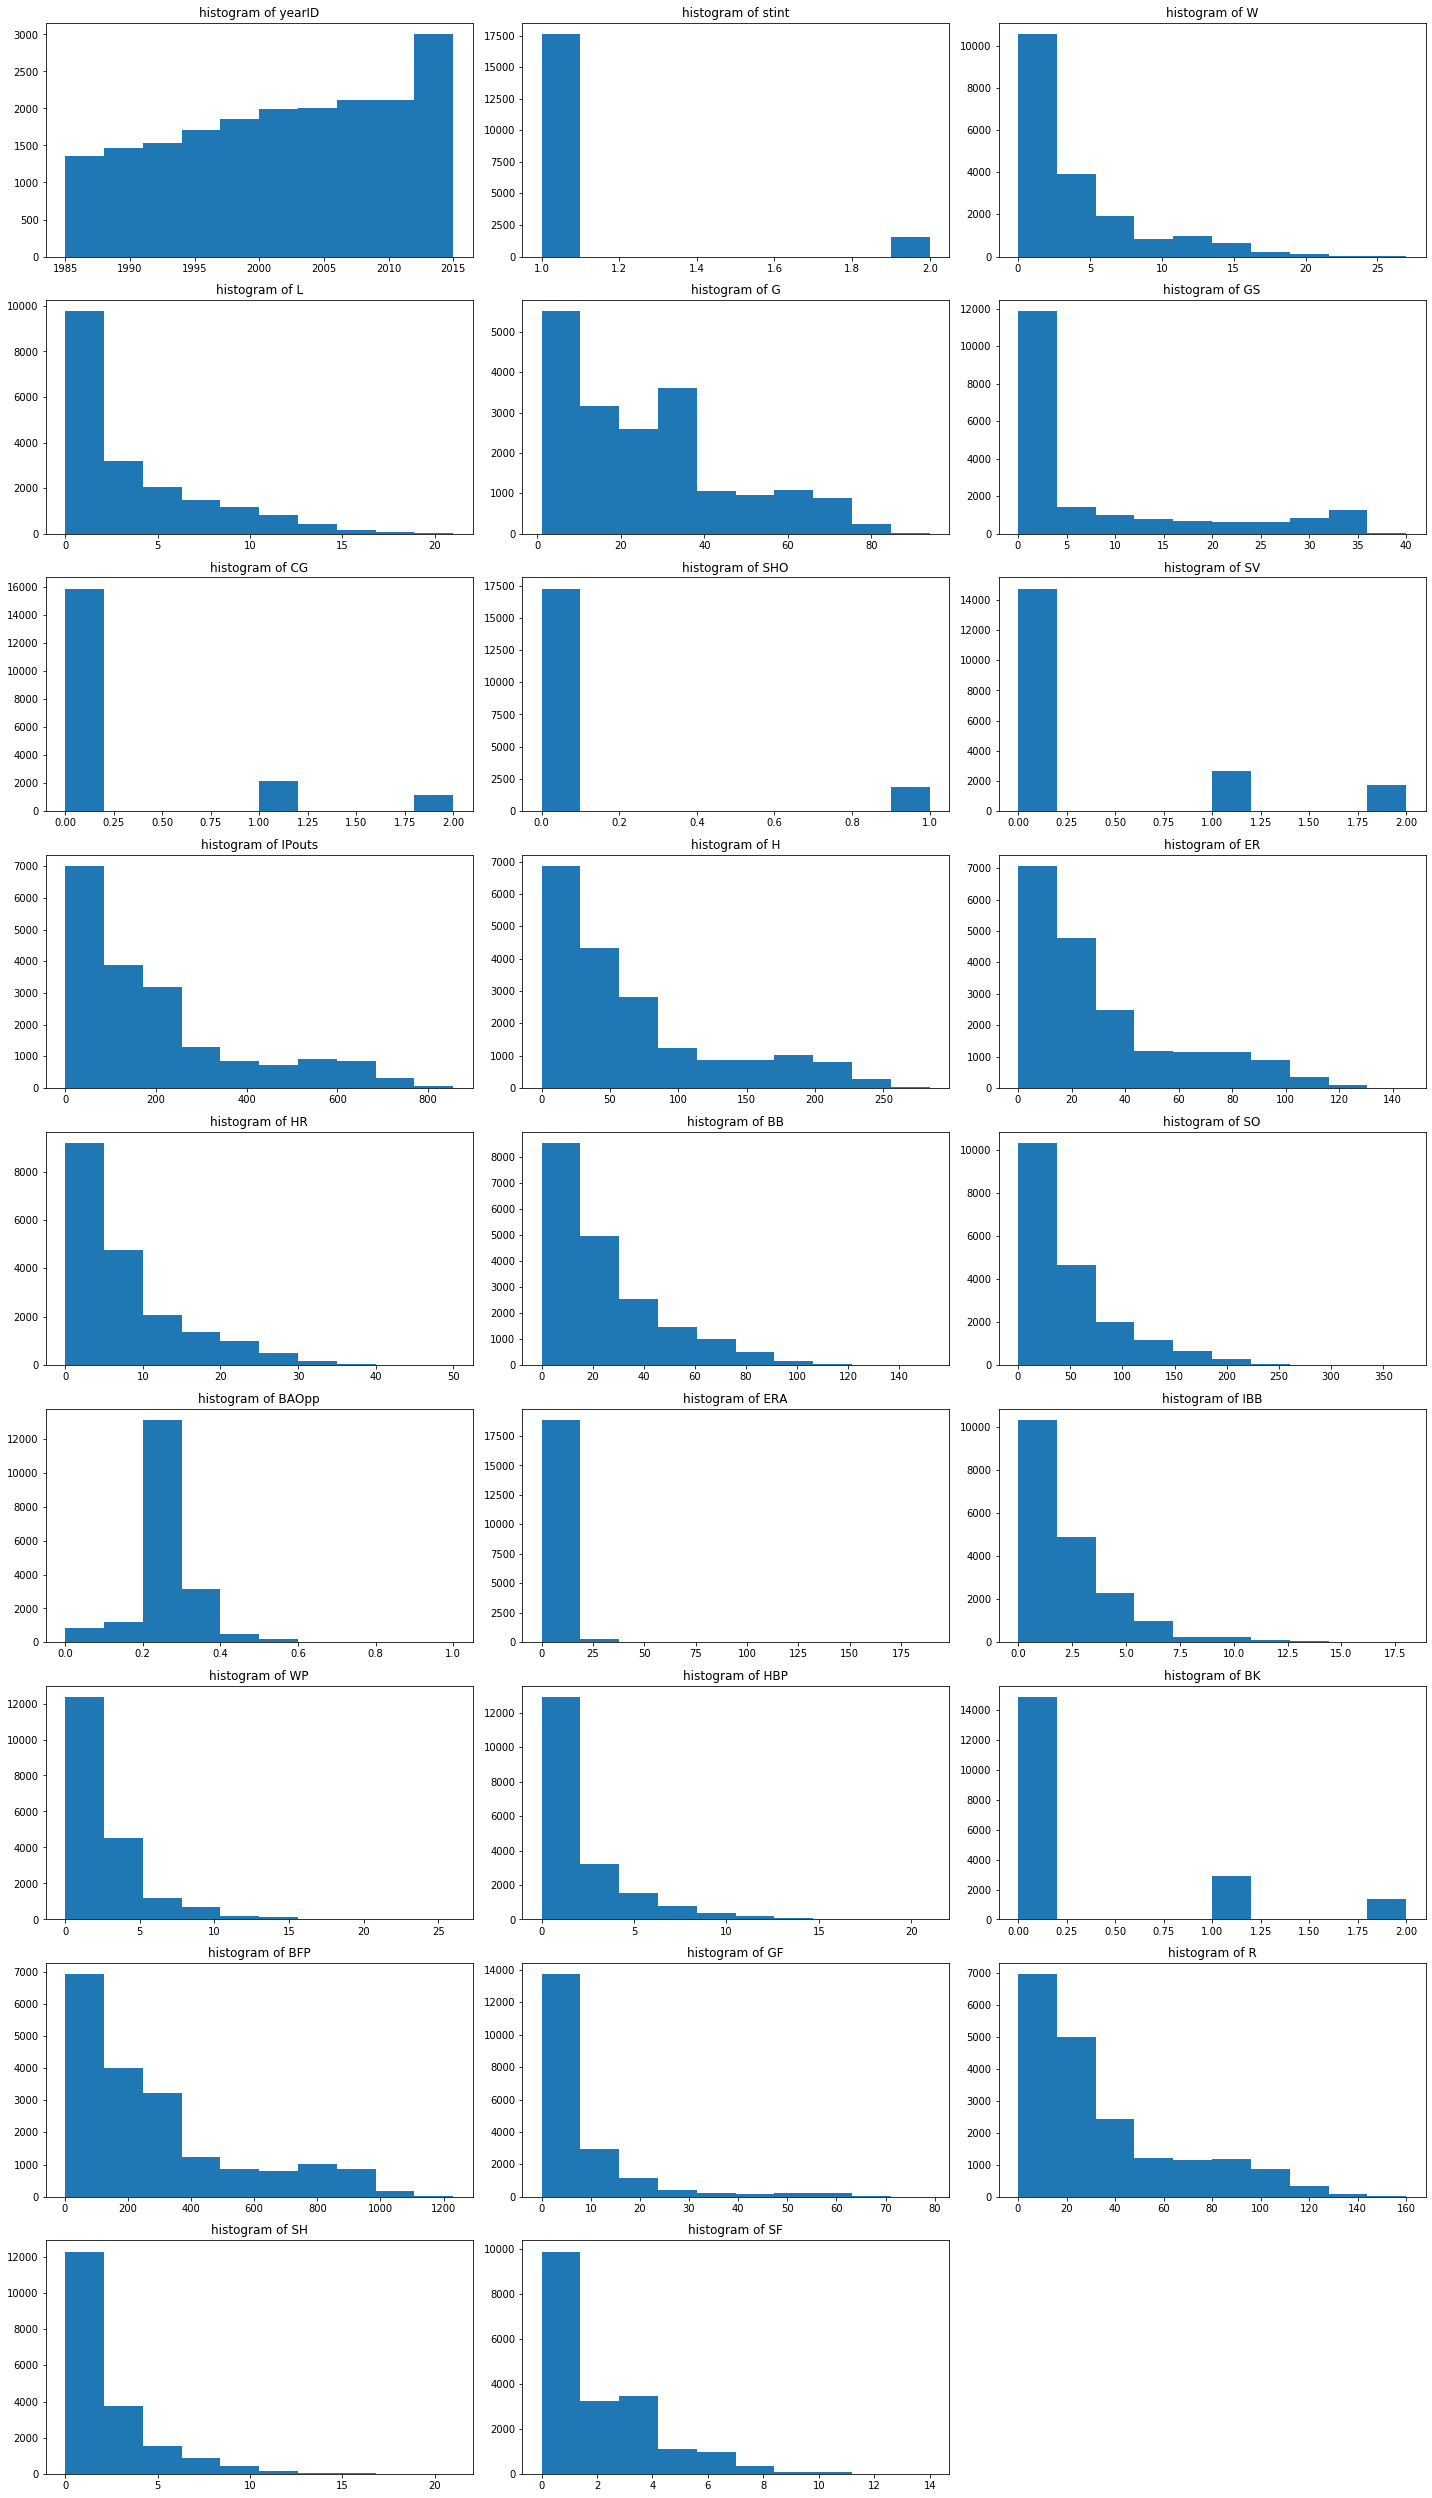

In [34]:
histogram(pitching,(20,100),3)

In [35]:
print(pitching.isnull().sum().sort_values(ascending=False))

SF          0
H           0
yearID      0
stint       0
teamID      0
lgID        0
W           0
L           0
G           0
GS          0
CG          0
SHO         0
SV          0
IPouts      0
ER          0
SH          0
HR          0
BB          0
SO          0
BAOpp       0
ERA         0
IBB         0
WP          0
HBP         0
BK          0
BFP         0
GF          0
R           0
playerID    0
dtype: int64


In [36]:
def numeric_columns(df):
    lst = list(df.select_dtypes(exclude=['object', 'category']))
    return lst

numeric_columns(pitching)

['yearID',
 'W',
 'L',
 'G',
 'GS',
 'IPouts',
 'H',
 'ER',
 'HR',
 'BB',
 'SO',
 'BAOpp',
 'ERA',
 'IBB',
 'WP',
 'HBP',
 'BFP',
 'GF',
 'R',
 'SH',
 'SF']

In [37]:
# checking pitching outliers 
check_outliers(pitching)

Number of outliers and percentage of it in yearID : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in W : 1264 and %6.597421577326583
percent of outliers low
0.0
Percent of outliers high
0.06597421577326583
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in L : 429 and %2.2391565321780886
percent of outliers low
0.0
Percent of outliers high
0.022391565321780885
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in G : 324 and %1.6911112270995354
percent of outliers low
0.0
Percent of outliers high
0.016911112270995354
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in GS : 1638 and %8.5495067592

In [38]:
pitching.describe()

yearID             W             L             G            GS  \
count  19159.000000  19159.000000  19159.000000  19159.000000  19159.000000   
mean    2001.424866      3.703795      3.703795     26.160029      7.409677   
std        8.741779      4.452438      3.852186     20.419301     11.134290   
min     1985.000000      0.000000      0.000000      1.000000      0.000000   
25%     1994.000000      0.000000      1.000000      9.000000      0.000000   
50%     2002.000000      2.000000      2.000000     22.000000      0.000000   
75%     2009.000000      5.000000      6.000000     35.000000     12.000000   
max     2015.000000     27.000000     21.000000     94.000000     40.000000   

             IPouts             H            ER            HR            BB  \
count  19159.000000  19159.000000  19159.000000  19159.000000  19159.000000   
mean     198.577483     66.319380     30.943473      7.280547     24.416201   
std      190.970907     63.048867     28.694744      7.427884     21.963373   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       48.000000     18.000000      9.000000      2.000000      7.000000   
50%      140.000000     46.000000     21.000000      5.000000     18.000000   
75%      268.000000     91.000000     44.000000     10.000000     35.000000   
max      856.000000    284.000000    145.000000     50.000000    152.000000   

       ...         BAOpp           ERA           IBB            WP  \
count  ...  19159.000000  19159.000000  19159.000000  19159.000000   
mean   ...      0.260535      5.344063      2.012631      2.391826   
std    ...      0.087154      5.477732      2.324798      2.771923   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.230000      3.370000      0.000000      0.000000   
50%    ...      0.260000      4.400000      1.000000      2.000000   
75%    ...      0.293000      5.840000      3.000000      4.000000   
max    ...      1.000000    189.000000     18.000000     26.000000   

                HBP           BFP            GF             R            SH  \
count  19159.000000  19159.000000  19159.000000  19159.000000  19159.000000   
mean       2.247195    284.753223      6.959131     33.840910      2.317002   
std        2.703916    267.955396     11.596099     31.342603      2.575438   
min        0.000000      1.000000      0.000000      0.000000      0.000000   
25%        0.000000     74.000000      0.000000     10.000000      0.000000   
50%        1.000000    205.000000      2.000000     23.000000      2.000000   
75%        3.000000    385.000000      9.000000     48.000000      3.000000   
max       21.000000   1231.000000     79.000000    160.000000     21.000000   

                 SF  
count  19159.000000  
mean       2.017025  
std        1.991420  
min        0.000000  
25%        0.500000  
50%        1.000000  
75%        3.000000  
max       14.000000  

[8 rows x 21 columns]

In [39]:
#winsorize those values and check if any outliers snuck through
winsorize_outliers(pitching)


In [40]:
check_outliers(pitching)

Number of outliers and percentage of it in yearID : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in W : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in L : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in G : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in GS : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
-------------------------------------------------------

In [41]:
#one variable always seems to sneak through
pitching['SO'] = winsorize(pitching['SO'], (0, 0.0485))
check_outliers(pitching)

Number of outliers and percentage of it in yearID : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in W : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in L : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in G : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in GS : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
-------------------------------------------------------

In [42]:
categorical_variables = ['stint', 'BK', 'CG', 'SHO', 'SV']


In [43]:
print(pitching[['stint', 'BK', 'CG', 'SHO', 'SV']].tail())

      stint BK CG SHO SV
44134     1  0  0   0  0
44135     1  0  0   0  2
44136     1  1  0   0  0
44137     1  0  0   0  0
44138     1  0  0   0  0


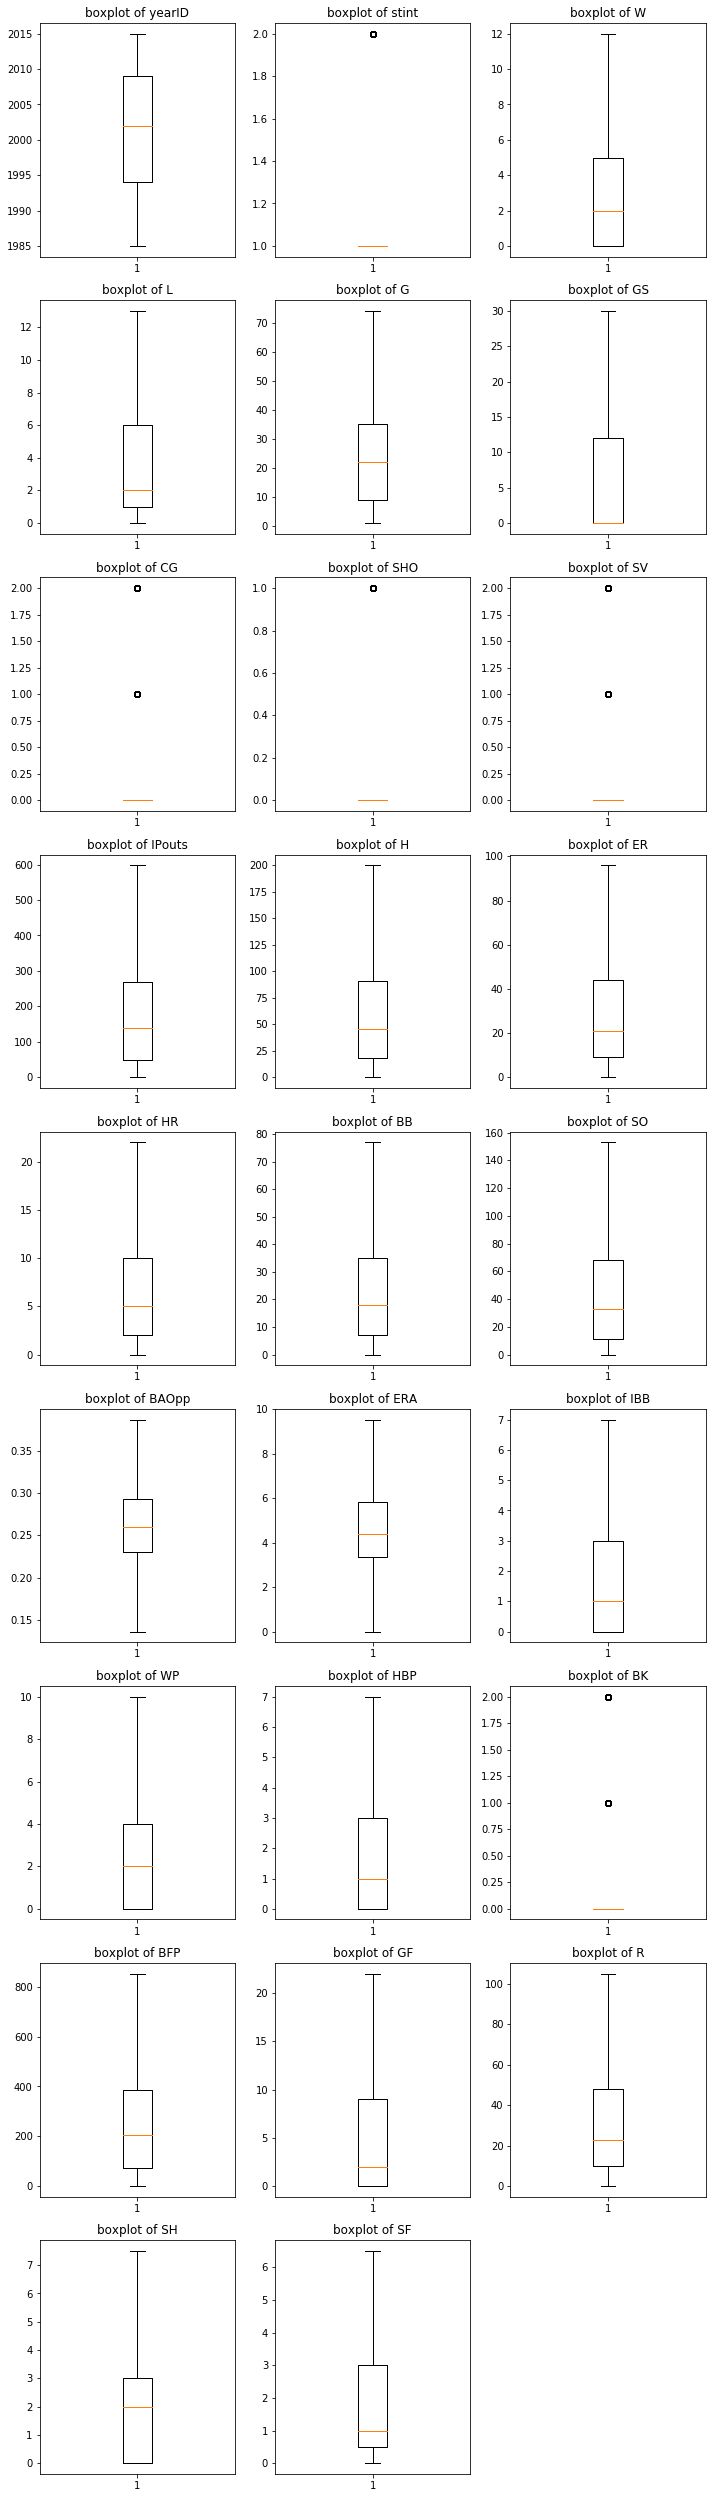

In [44]:
boxplot(pitching, (10,100), 3)

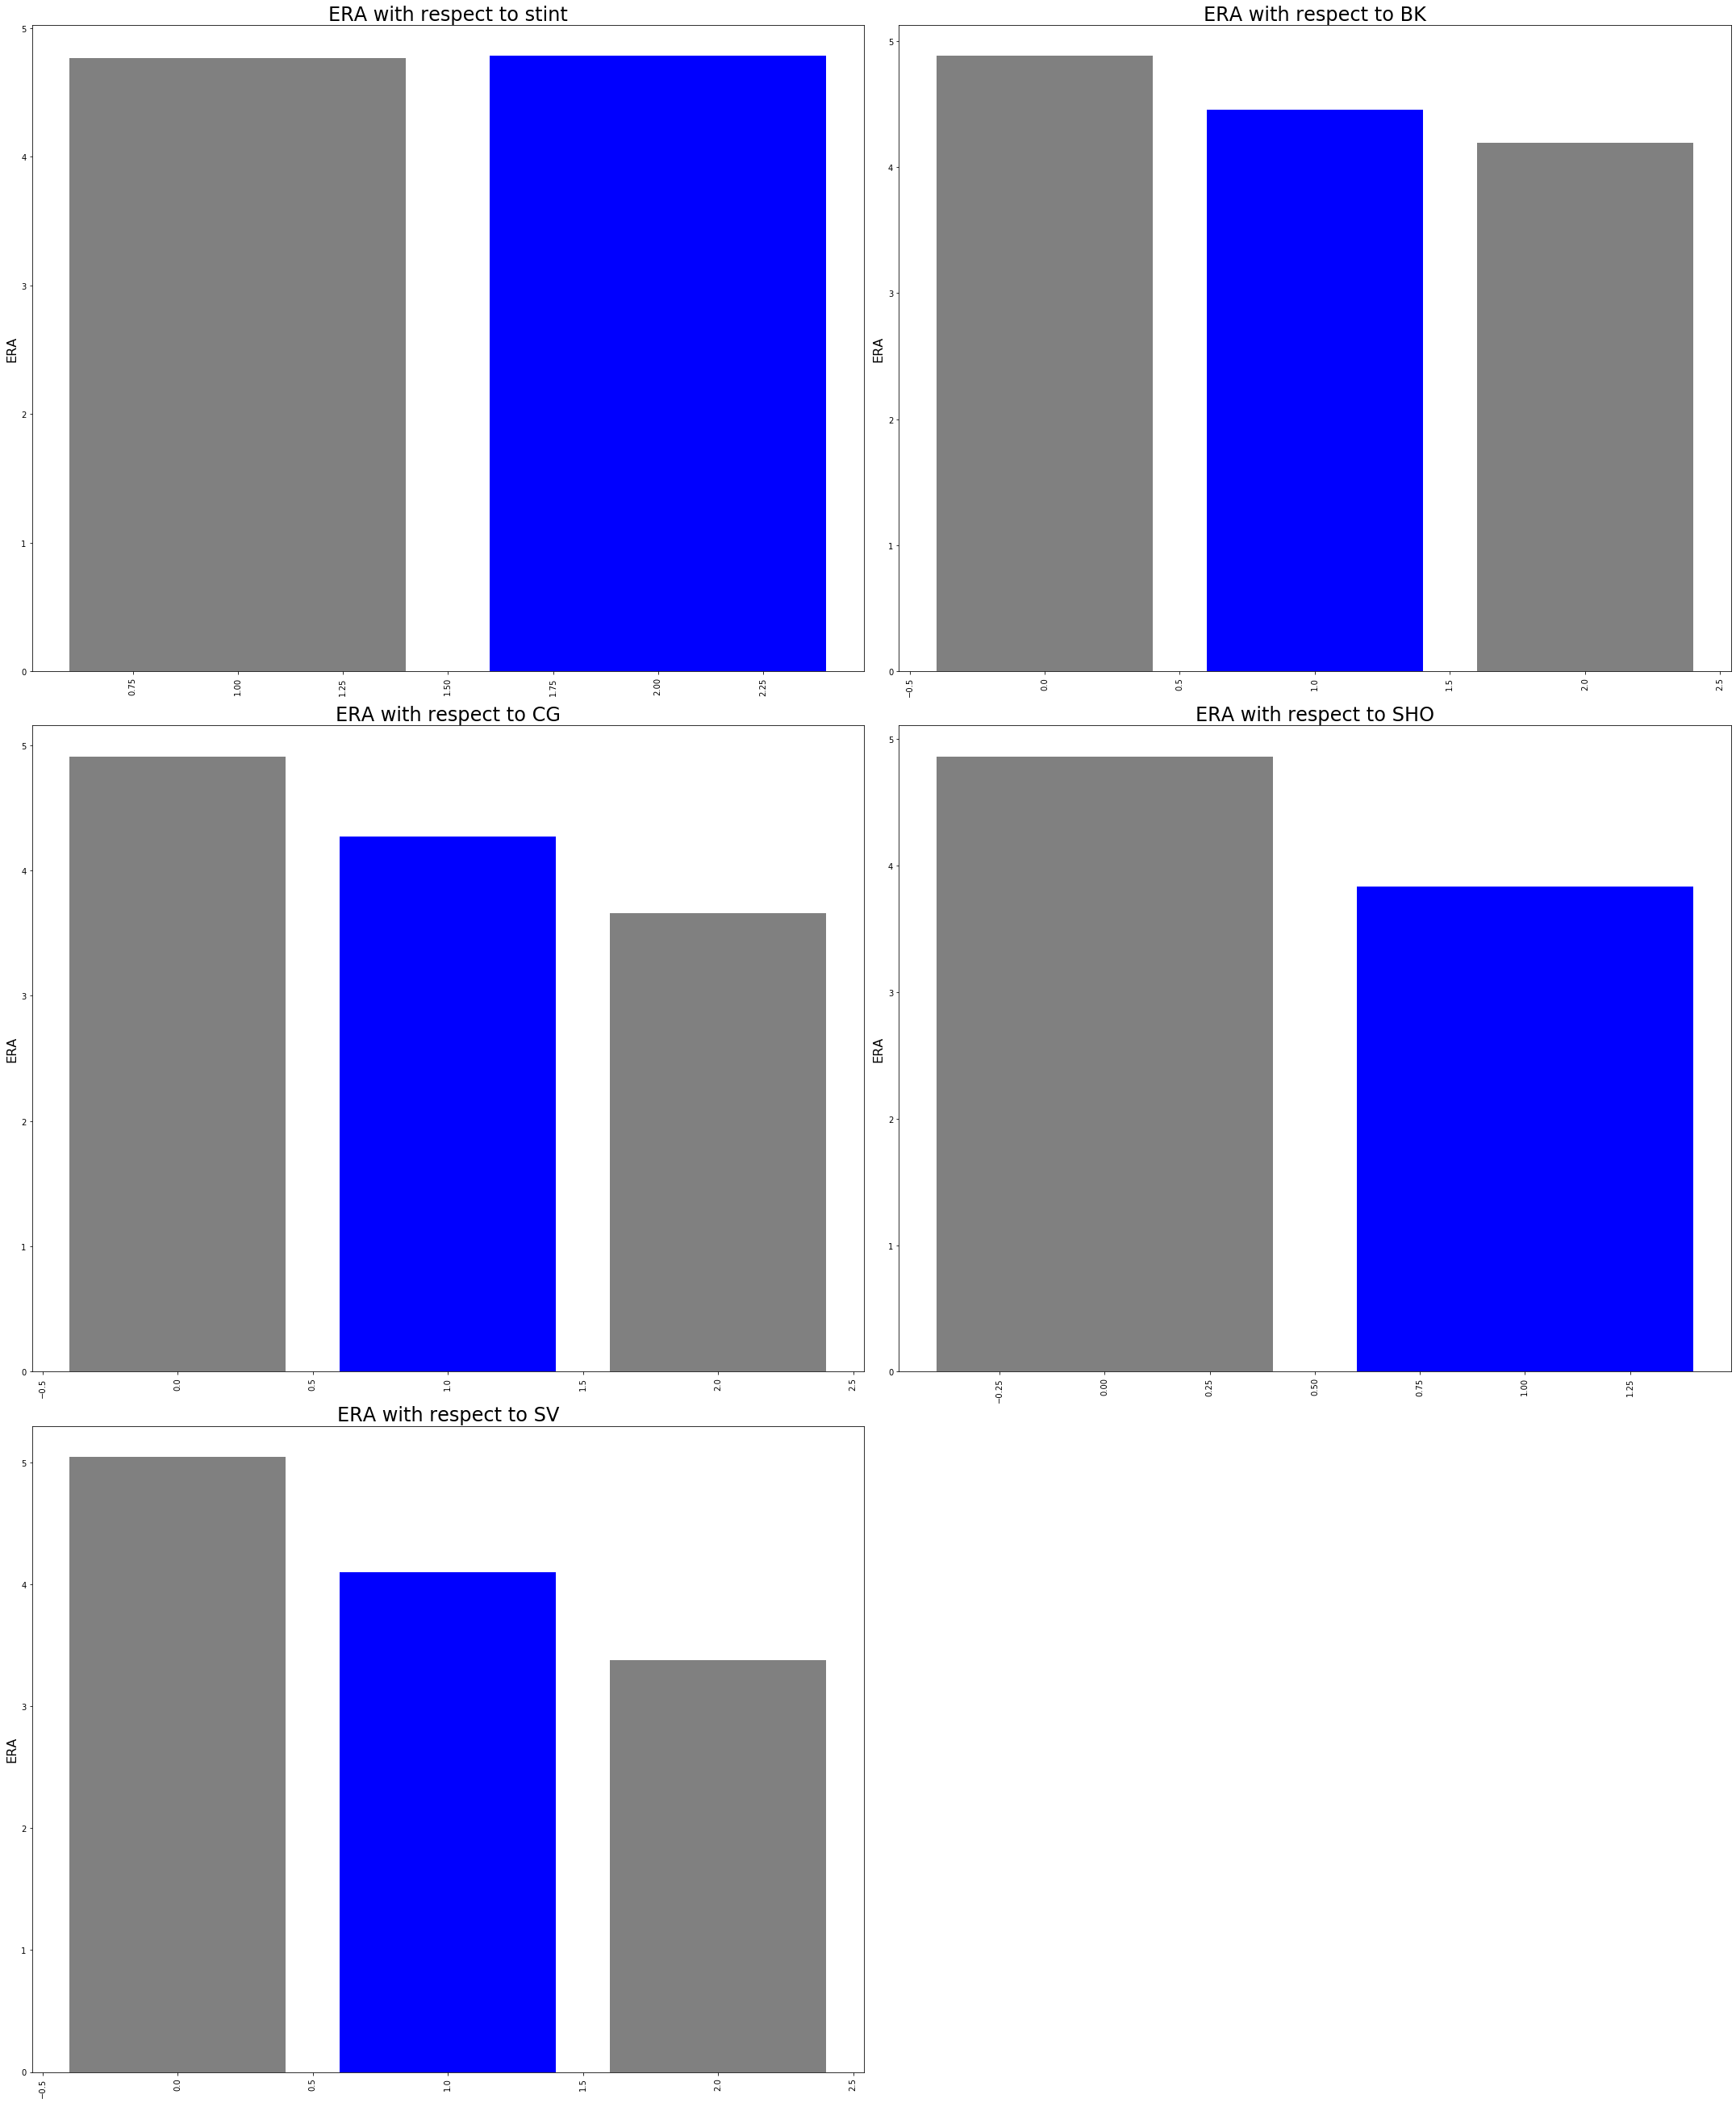

In [45]:
categorical_variables = ['stint', 'BK', 'CG', 'SHO', 'SV']


plt.figure(figsize=(30, 60))
for i, col in enumerate(categorical_variables):
    plt.subplot(len(categorical_variables), 2, i+1)
    plt.bar(pitching.groupby(col)['ERA'].mean(
    ).index, pitching.groupby(col)['ERA'].mean(), color=('grey', 'blue'))
    plt.ylabel('ERA',fontsize=16)
    plt.xticks(rotation='vertical')
    plt.title('ERA with respect to {}'.format(col), fontsize=24)
    plt.tight_layout()
    #there's a lot of noise in the Nationality and Club

In [46]:
### So these all make sense. 

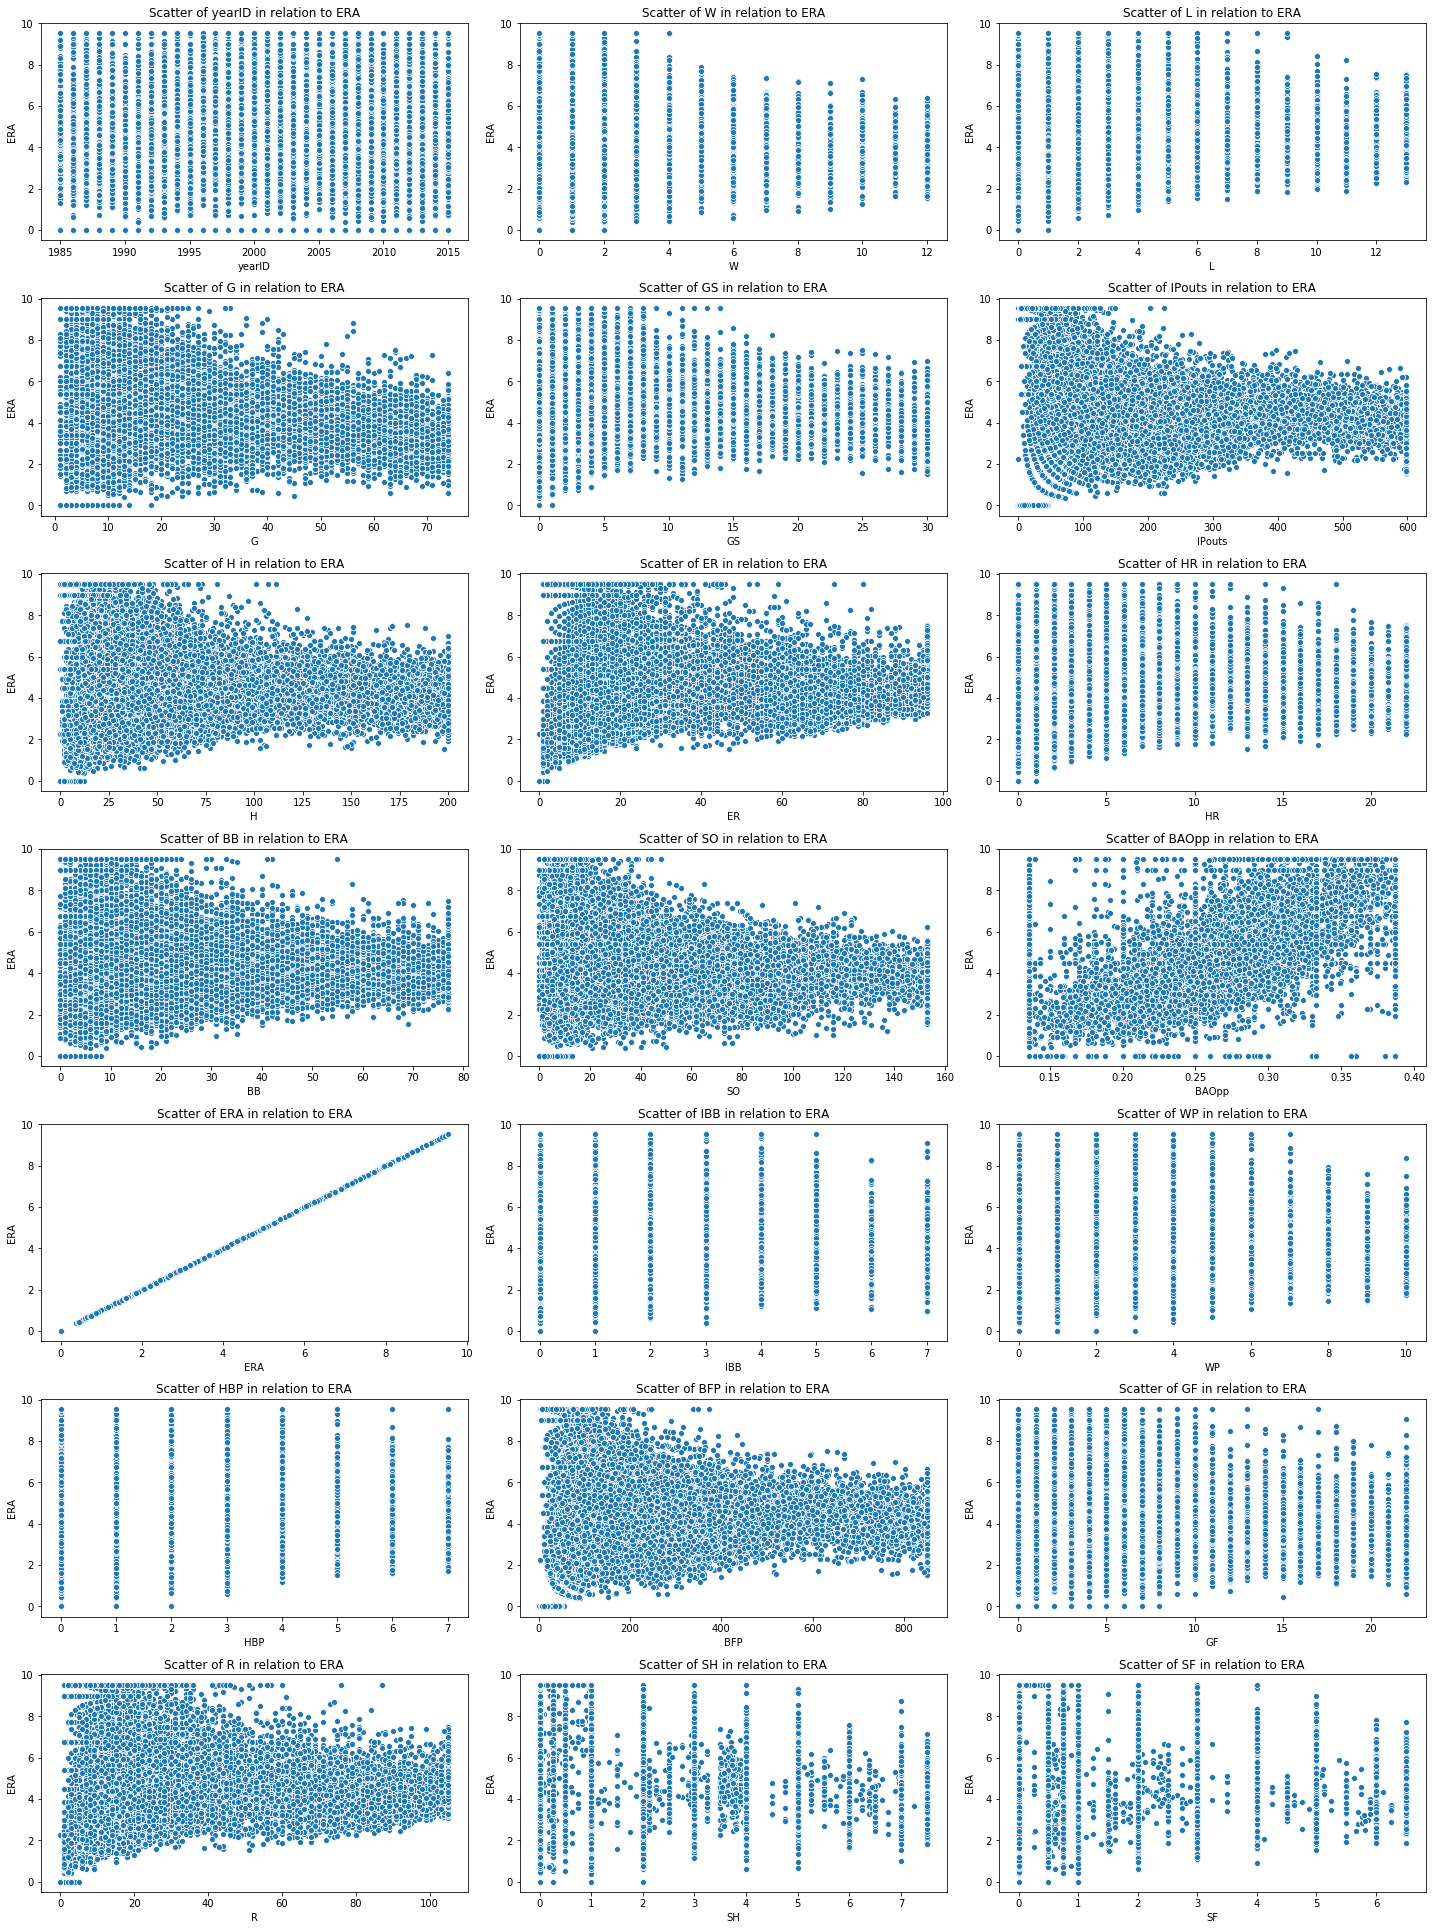

In [47]:
## Checking ERA to the rest of our numeric variables
scatter(pitching, 'ERA', (20,80), 3)

In [48]:
print(salary['playerID'].isin(pitching['playerID']).value_counts())


True     13024
False    12551
Name: playerID, dtype: int64


### So I will be merging my salary df with salary. My goal is to create a variable using ERA and salary to find undervalued players. Maybe we can pick up a great player for a steal in our next fantasy draft. I'll need to deal with any outliers in salary if there are any.

In [49]:
print(pitching.info(), salary.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19159 entries, 24980 to 44138
Data columns (total 29 columns):
playerID    19159 non-null object
yearID      19159 non-null int64
stint       19159 non-null category
teamID      19159 non-null object
lgID        19159 non-null object
W           19159 non-null int64
L           19159 non-null int64
G           19159 non-null int64
GS          19159 non-null int64
CG          19159 non-null category
SHO         19159 non-null category
SV          19159 non-null category
IPouts      19159 non-null float64
H           19159 non-null int64
ER          19159 non-null int64
HR          19159 non-null int64
BB          19159 non-null int64
SO          19159 non-null int64
BAOpp       19159 non-null float64
ERA         19159 non-null float64
IBB         19159 non-null float64
WP          19159 non-null float64
HBP         19159 non-null float64
BK          19159 non-null category
BFP         19159 non-null float64
GF          19159 non-null flo

In [50]:
print(salary.isnull().sum())

yearID      0
teamID      0
lgID        0
playerID    0
salary      0
dtype: int64


In [51]:
#no missing values. Time to check outliers
check_outliers(salary)
winsorize_outliers(salary)

Number of outliers and percentage of it in yearID : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in salary : 2848 and %11.135874877810362
percent of outliers low
0.0
Percent of outliers high
0.11135874877810362
------------------------------------------------------------------------------------------


In [52]:
check_outliers(salary)

Number of outliers and percentage of it in yearID : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in salary : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------


### Now I will merge and make sure nothing went awry, then I'll start my analysis

In [53]:
pitching_salary = pd.merge(pitching, salary, on=['playerID','lgID','yearID'])

In [54]:
print(pitching_salary.info())
print(pitching_salary.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12199 entries, 0 to 12198
Data columns (total 31 columns):
playerID    12199 non-null object
yearID      12199 non-null int64
stint       12199 non-null category
teamID_x    12199 non-null object
lgID        12199 non-null object
W           12199 non-null int64
L           12199 non-null int64
G           12199 non-null int64
GS          12199 non-null int64
CG          12199 non-null category
SHO         12199 non-null category
SV          12199 non-null category
IPouts      12199 non-null float64
H           12199 non-null int64
ER          12199 non-null int64
HR          12199 non-null int64
BB          12199 non-null int64
SO          12199 non-null int64
BAOpp       12199 non-null float64
ERA         12199 non-null float64
IBB         12199 non-null float64
WP          12199 non-null float64
HBP         12199 non-null float64
BK          12199 non-null category
BFP         12199 non-null float64
GF          12199 non-null float64

In [55]:
# a quick look at the new df
pitching_salary.describe()

yearID             W             L             G            GS  \
count  12199.000000  12199.000000  12199.000000  12199.000000  12199.000000   
mean    2000.783015      4.636446      4.777359     32.881958      9.560292   
std        8.572208      4.072517      3.901910     20.181745     11.920686   
min     1985.000000      0.000000      0.000000      1.000000      0.000000   
25%     1994.000000      1.000000      1.000000     17.000000      0.000000   
50%     2001.000000      3.000000      4.000000     31.000000      1.000000   
75%     2008.000000      8.000000      8.000000     46.000000     21.000000   
max     2015.000000     12.000000     13.000000     74.000000     30.000000   

            IPouts             H            ER            HR            BB  \
count  12199.00000  12199.000000  12199.000000  12199.000000  12199.000000   
mean     254.19600     84.494877     39.124518      8.905812     30.673498   
std      189.66334     63.228841     29.179763      6.987321     21.562769   
min        0.00000      0.000000      0.000000      0.000000      0.000000   
25%      104.00000     35.000000     16.000000      3.000000     14.000000   
50%      202.00000     63.000000     29.000000      7.000000     26.000000   
75%      394.00000    135.000000     63.000000     14.000000     45.000000   
max      598.00000    200.000000     96.000000     22.000000     77.000000   

       ...           ERA           IBB            WP           HBP  \
count  ...  12199.000000  12199.000000  12199.000000  12199.000000   
mean   ...      4.492008      2.442577      2.946061      2.603738   
std    ...      1.866774      2.157770      2.702505      2.297986   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      3.320000      1.000000      1.000000      1.000000   
50%    ...      4.200000      2.000000      2.000000      2.000000   
75%    ...      5.330000      4.000000      4.000000      4.000000   
max    ...      9.530000      7.000000     10.000000      7.000000   

                BFP            GF             R            SH            SF  \
count  12199.000000  12199.000000  12199.000000  12199.000000  12199.000000   
mean     364.890565      6.783999     42.841298      2.881607      2.504459   
std      268.683276      7.834385     31.876582      2.341884      1.940903   
min        1.000000      0.000000      0.000000      0.000000      0.000000   
25%      152.000000      0.000000     18.000000      1.000000      1.000000   
50%      287.000000      3.000000     32.000000      2.000000      2.000000   
75%      569.000000     12.000000     69.000000      4.000000      4.000000   
max      851.000000     22.000000    105.000000      7.500000      6.500000   

             salary  
count  1.219900e+04  
mean   1.440513e+06  
std    1.680848e+06  
min    6.000000e+04  
25%    2.750000e+05  
50%    5.295000e+05  
75%    2.125000e+06  
max    5.200000e+06  

[8 rows x 22 columns]

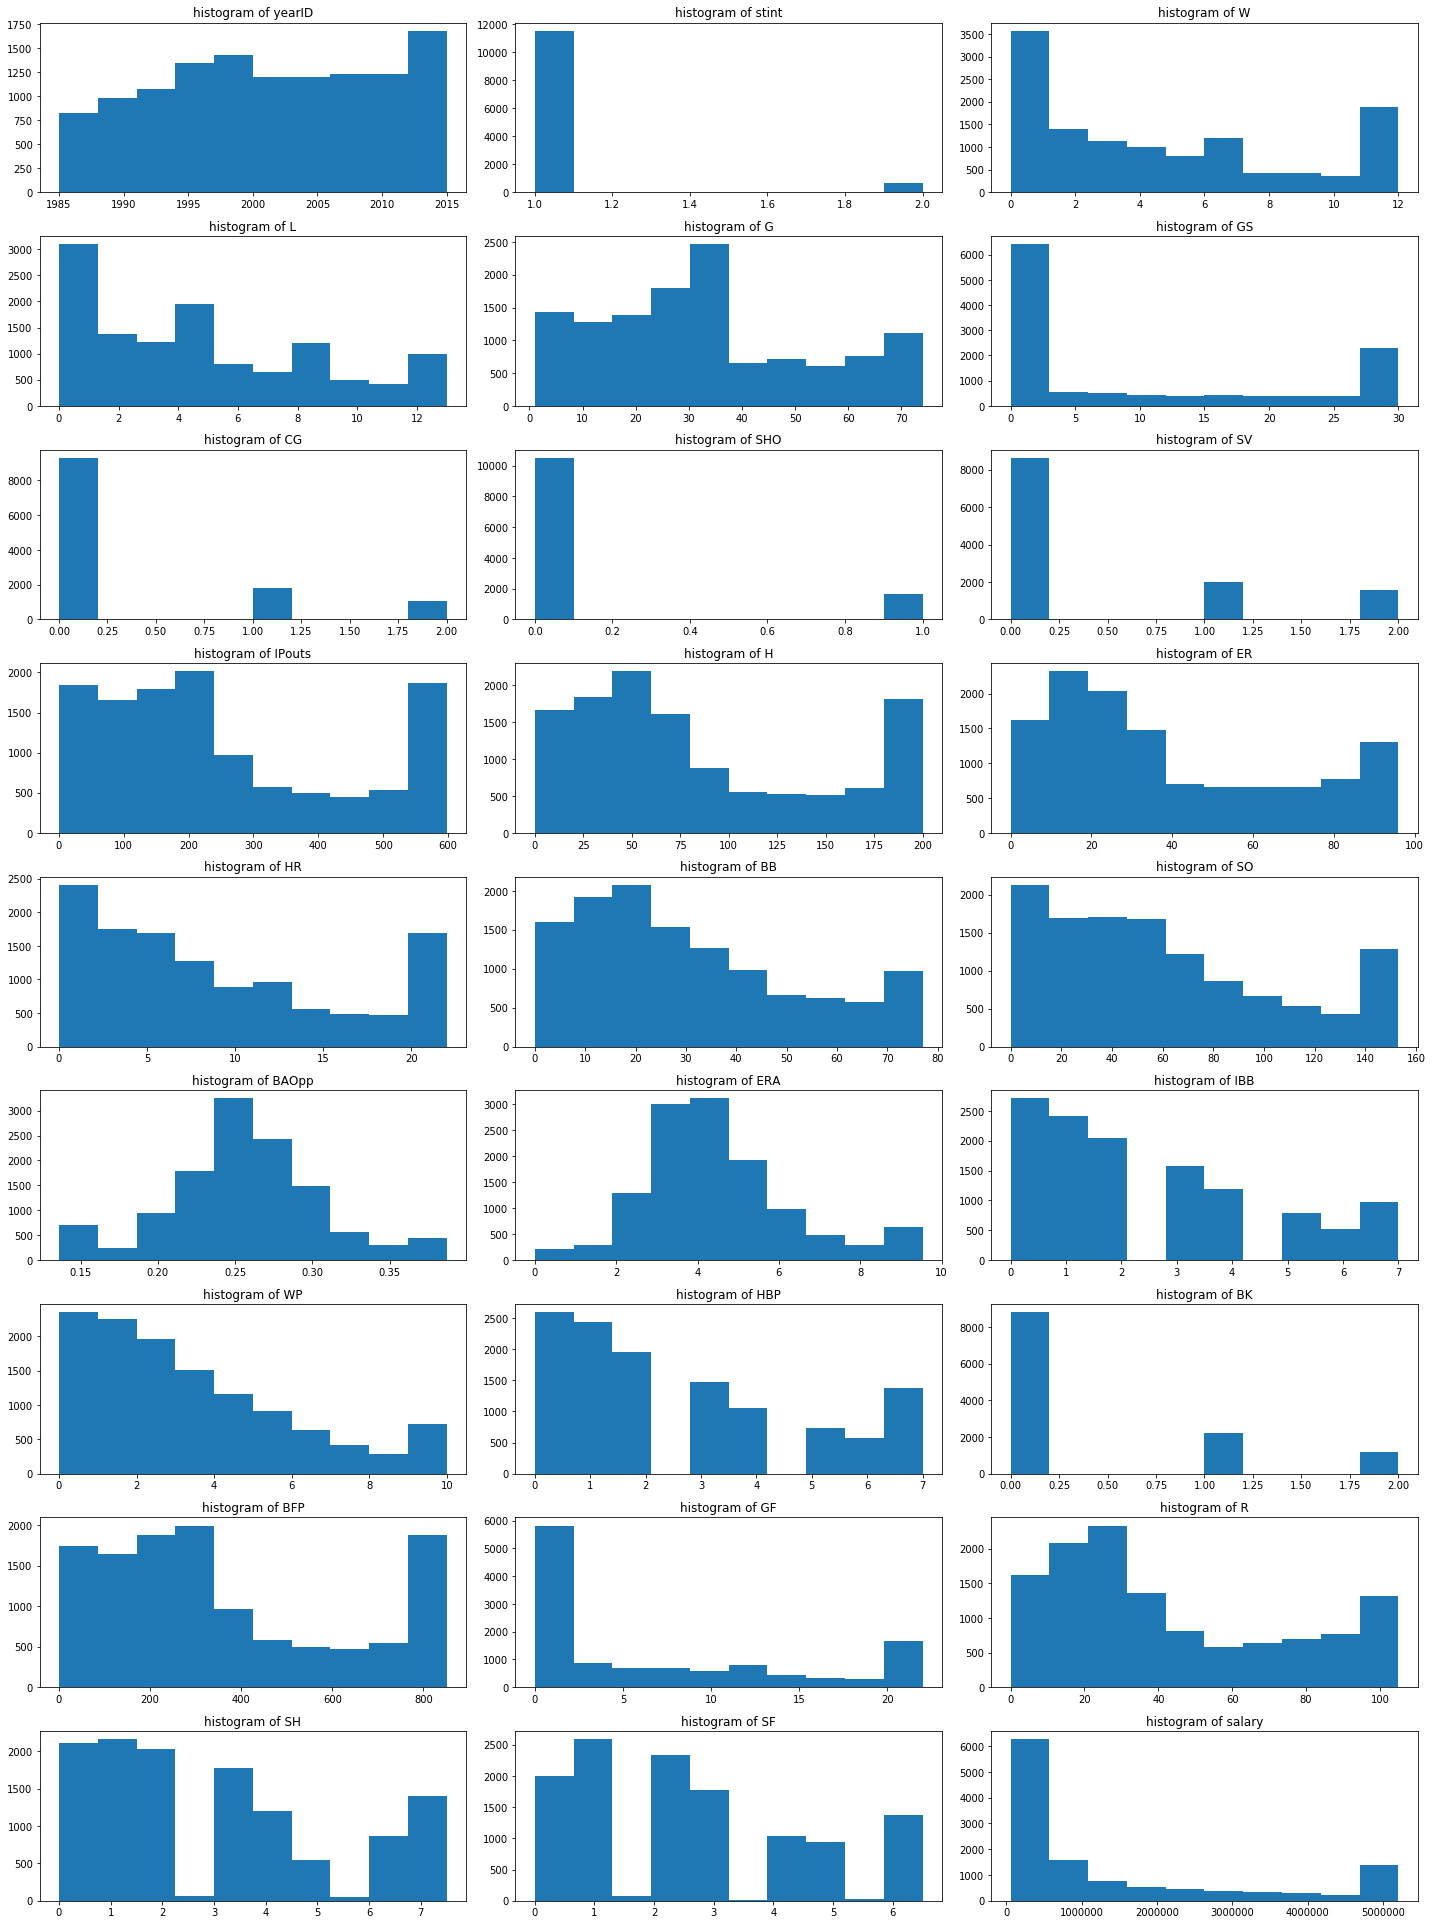

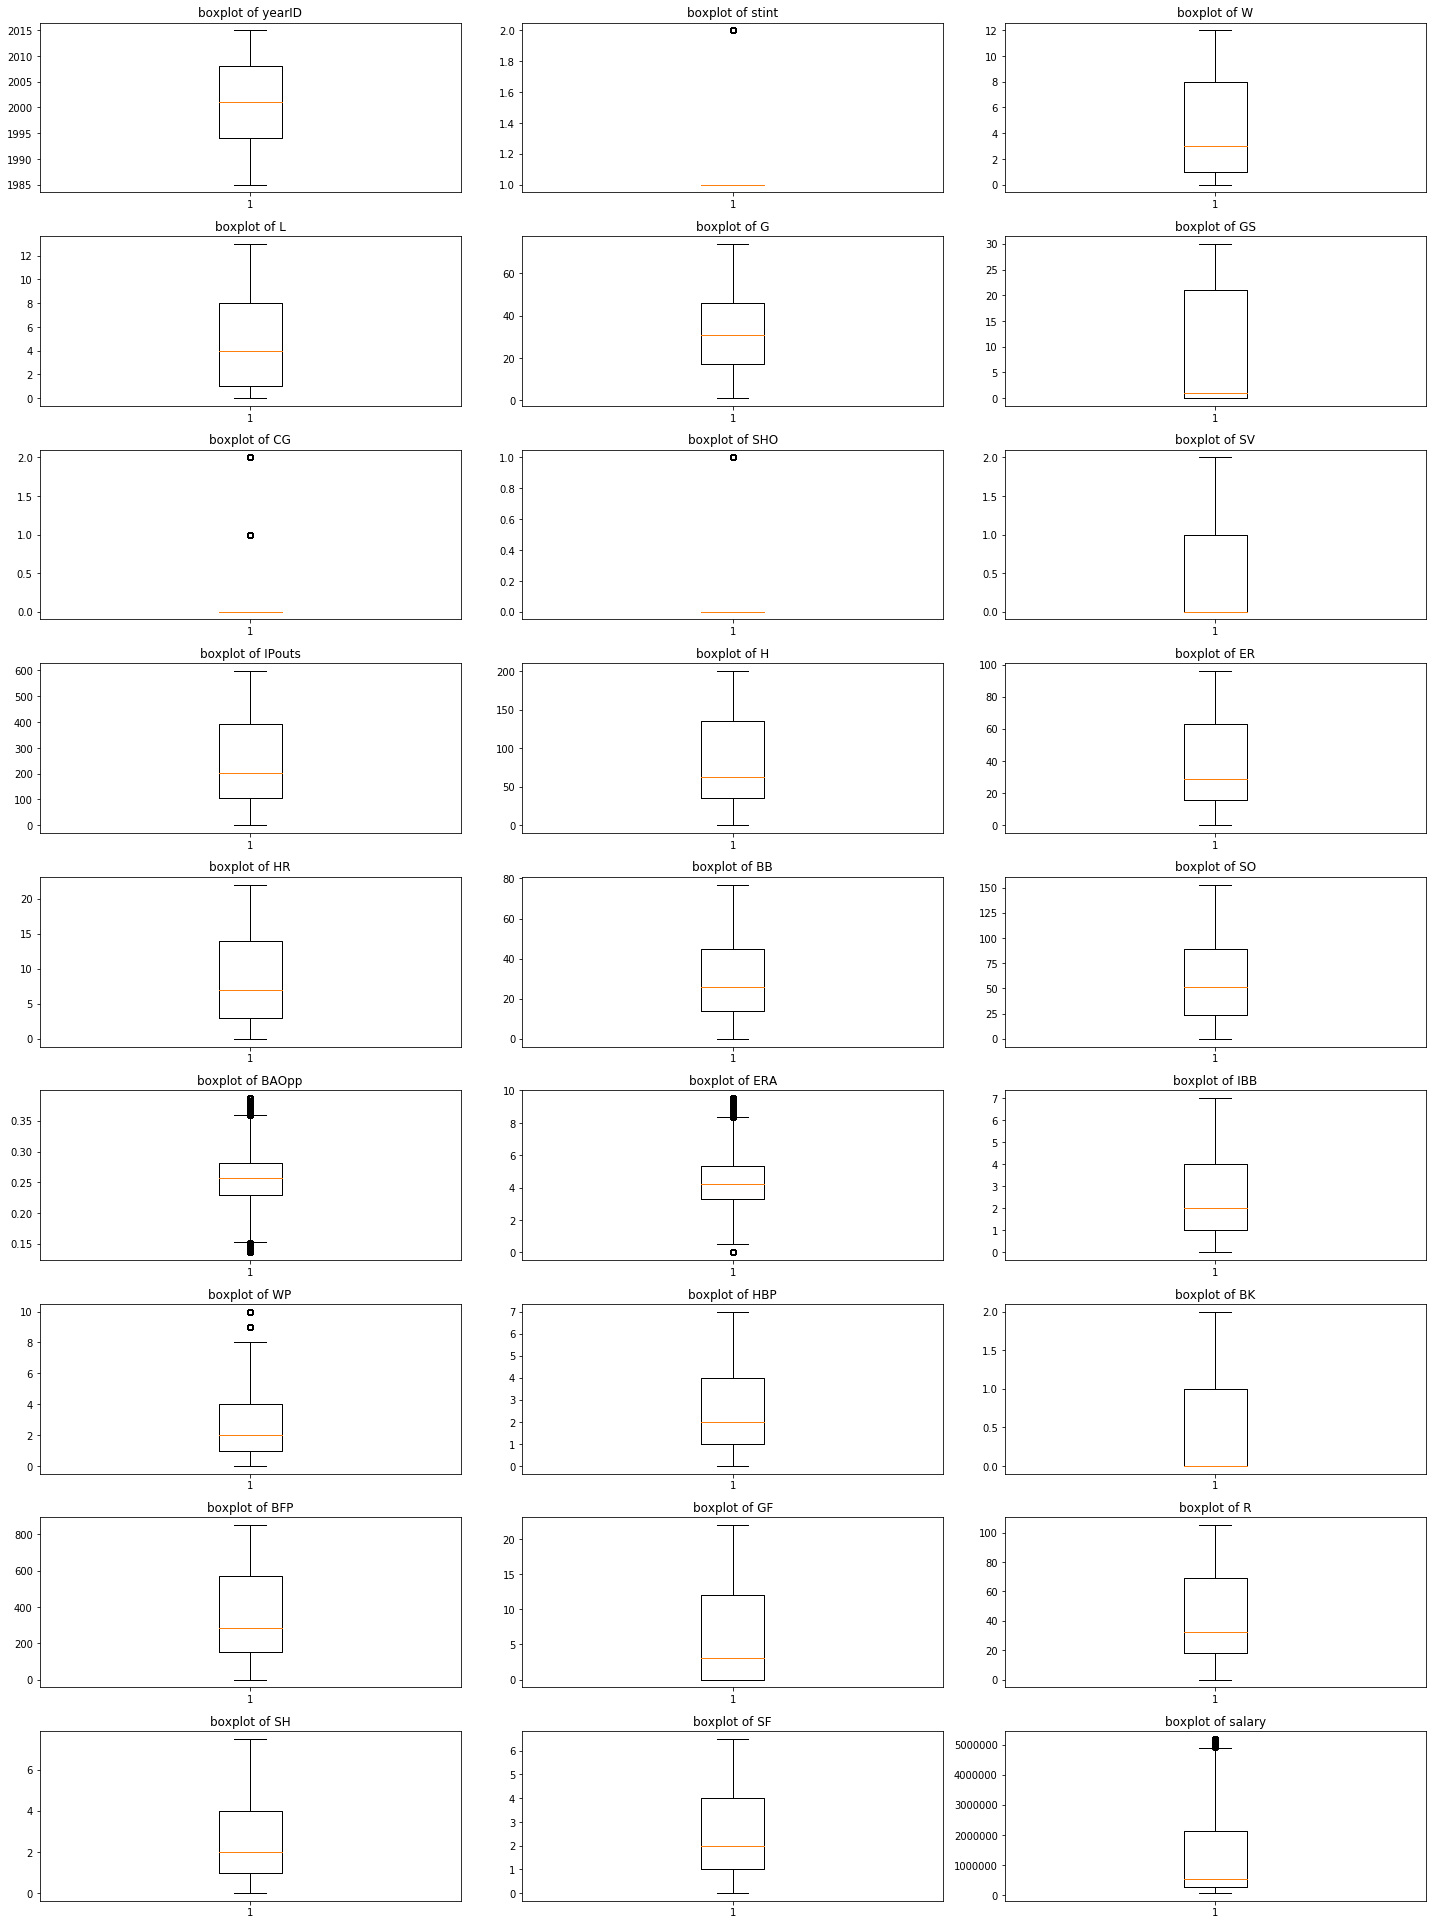

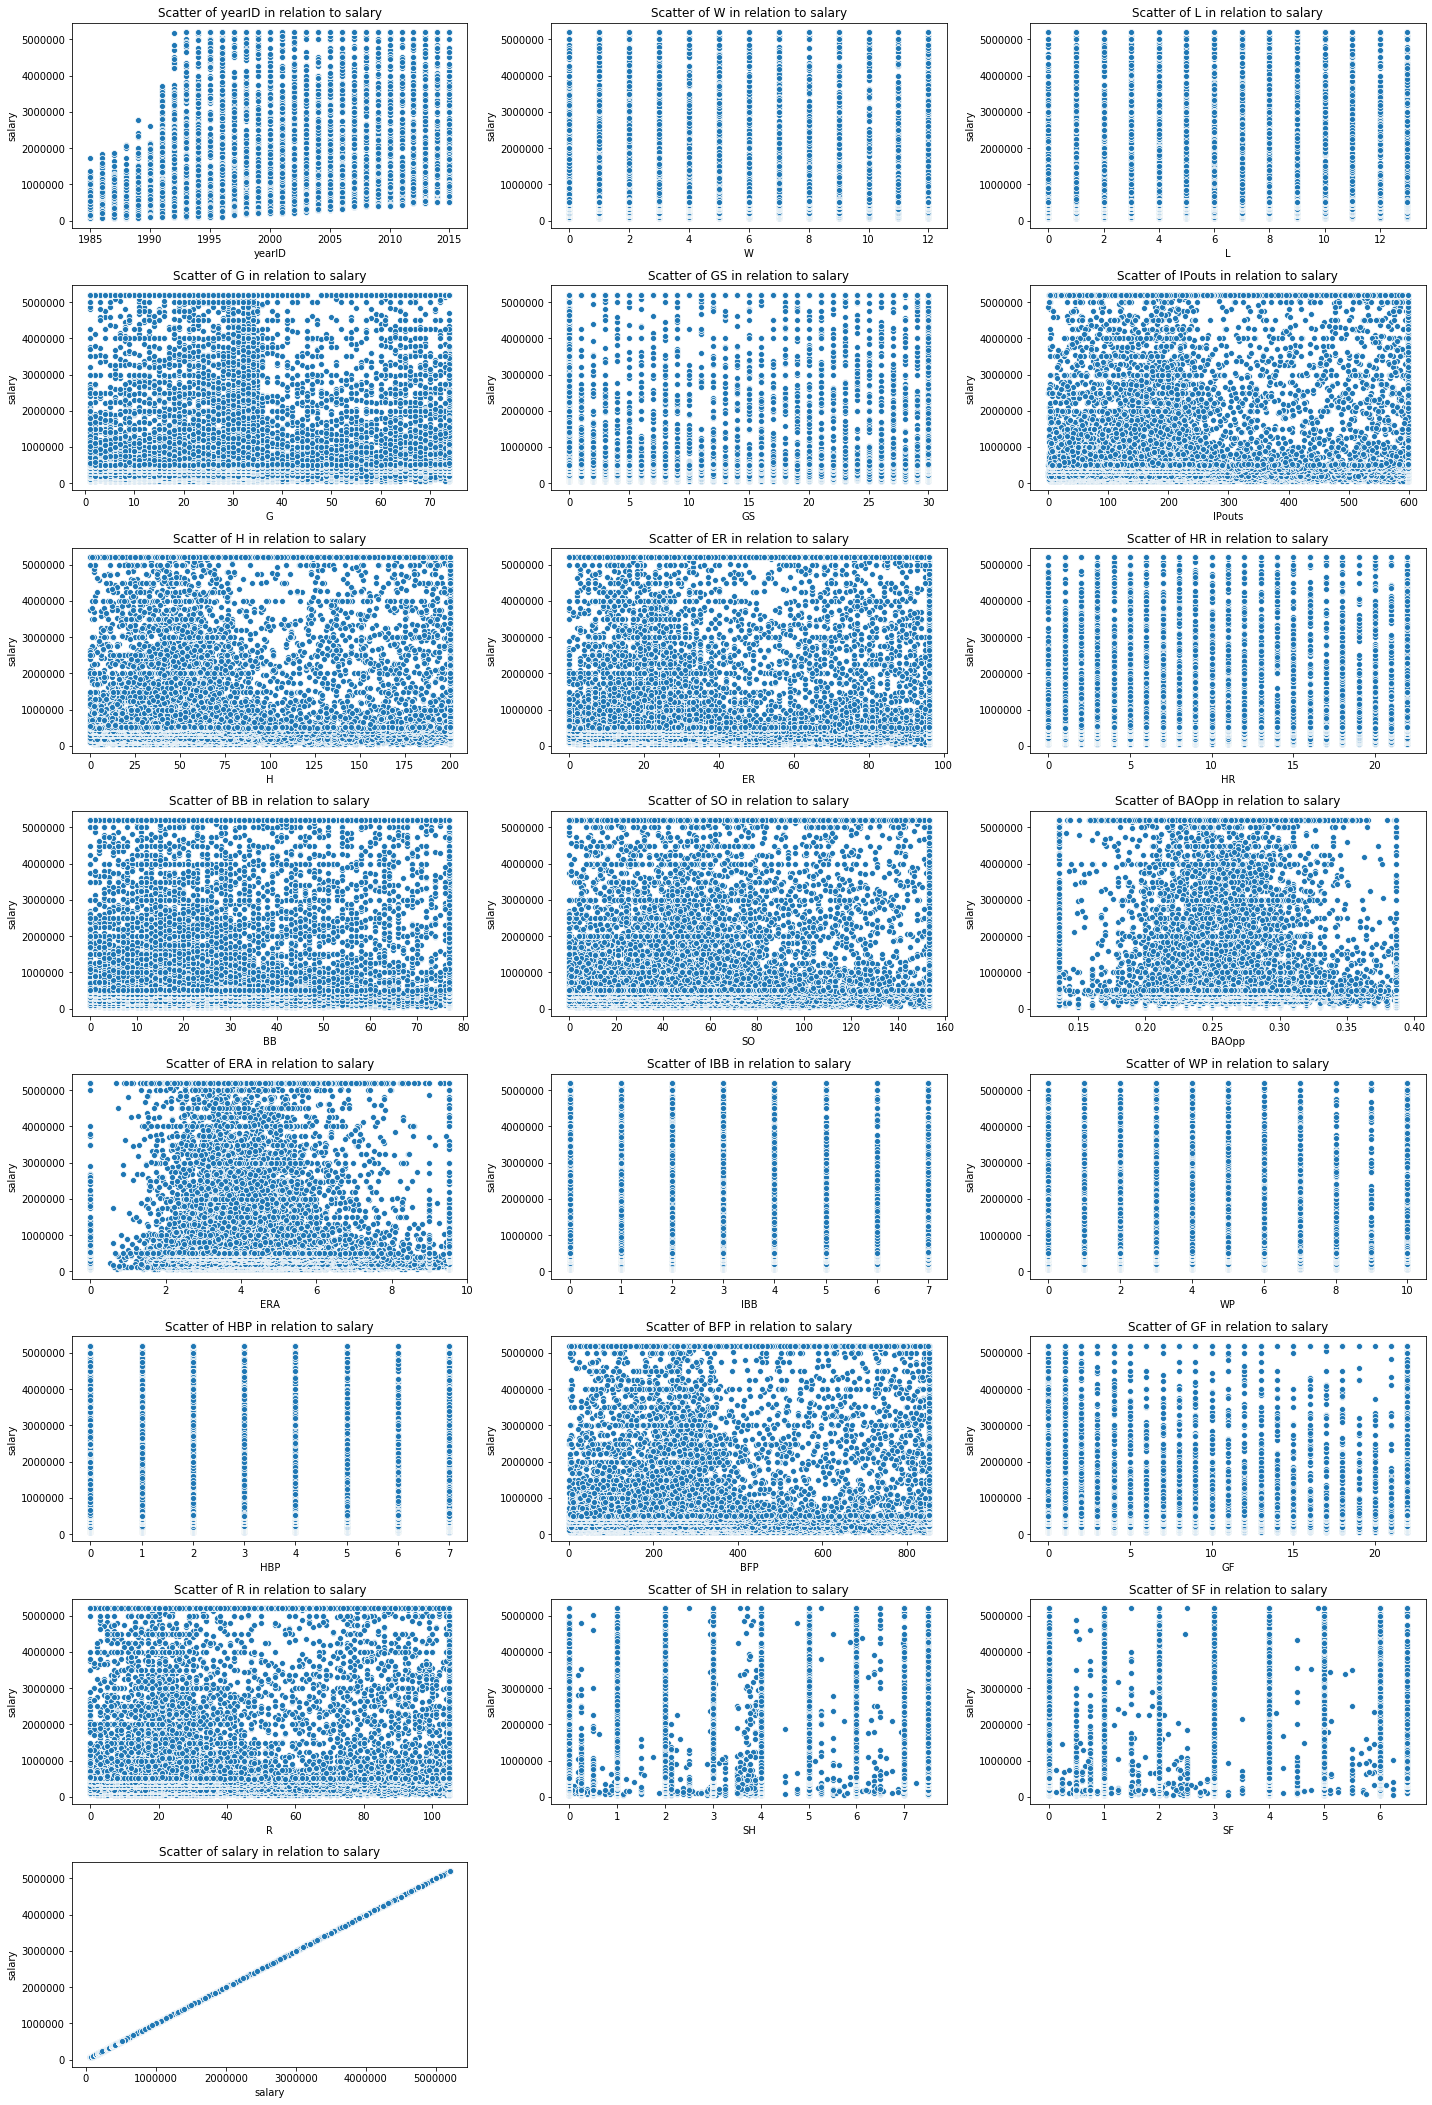

In [56]:
histogram(pitching_salary, (20,80), 3)
boxplot(pitching_salary, (20,80), 3)
scatter(pitching_salary, 'salary', (20,80),3)

In [57]:
check_outliers(pitching_salary)
winsorize_outliers(pitching_salary)

Number of outliers and percentage of it in yearID : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in W : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in L : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in G : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in GS : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
-------------------------------------------------------

In [58]:
check_outliers(pitching_salary)

Number of outliers and percentage of it in yearID : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in W : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in L : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in G : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in GS : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
-------------------------------------------------------

### A lot of work to get here, but now I'll define my target variable


In [59]:
ERA = sorted(list(pitching_salary['ERA'].unique()))
print(ERA)

[0.51, 0.6, 0.61, 0.62, 0.66, 0.68, 0.69, 0.72, 0.73, 0.74, 0.75, 0.79, 0.82, 0.84, 0.86, 0.87, 0.9, 0.92, 0.93, 0.94, 0.95, 0.96, 0.98, 1.0, 1.01, 1.03, 1.04, 1.06, 1.08, 1.09, 1.11, 1.12, 1.13, 1.19, 1.2, 1.21, 1.23, 1.25, 1.26, 1.27, 1.29, 1.3, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4, 1.41, 1.42, 1.43, 1.44, 1.45, 1.47, 1.48, 1.49, 1.5, 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59, 1.6, 1.61, 1.62, 1.63, 1.64, 1.65, 1.66, 1.67, 1.68, 1.69, 1.7, 1.71, 1.72, 1.73, 1.74, 1.75, 1.76, 1.77, 1.78, 1.79, 1.8, 1.81, 1.82, 1.83, 1.84, 1.85, 1.86, 1.87, 1.88, 1.89, 1.9, 1.91, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.99, 2.0, 2.01, 2.02, 2.03, 2.04, 2.05, 2.06, 2.07, 2.08, 2.09, 2.1, 2.11, 2.12, 2.13, 2.14, 2.15, 2.16, 2.17, 2.18, 2.19, 2.2, 2.21, 2.22, 2.23, 2.24, 2.25, 2.26, 2.27, 2.28, 2.29, 2.3, 2.31, 2.32, 2.33, 2.34, 2.35, 2.36, 2.37, 2.38, 2.39, 2.4, 2.41, 2.42, 2.43, 2.44, 2.45, 2.46, 2.47, 2.48, 2.49, 2.5, 2.51, 2.52, 2.53, 2.54, 2.55, 2.56, 2.57, 2.58, 2.59, 2.

### I think I'll multiply salary and ERA. The lower the number the better

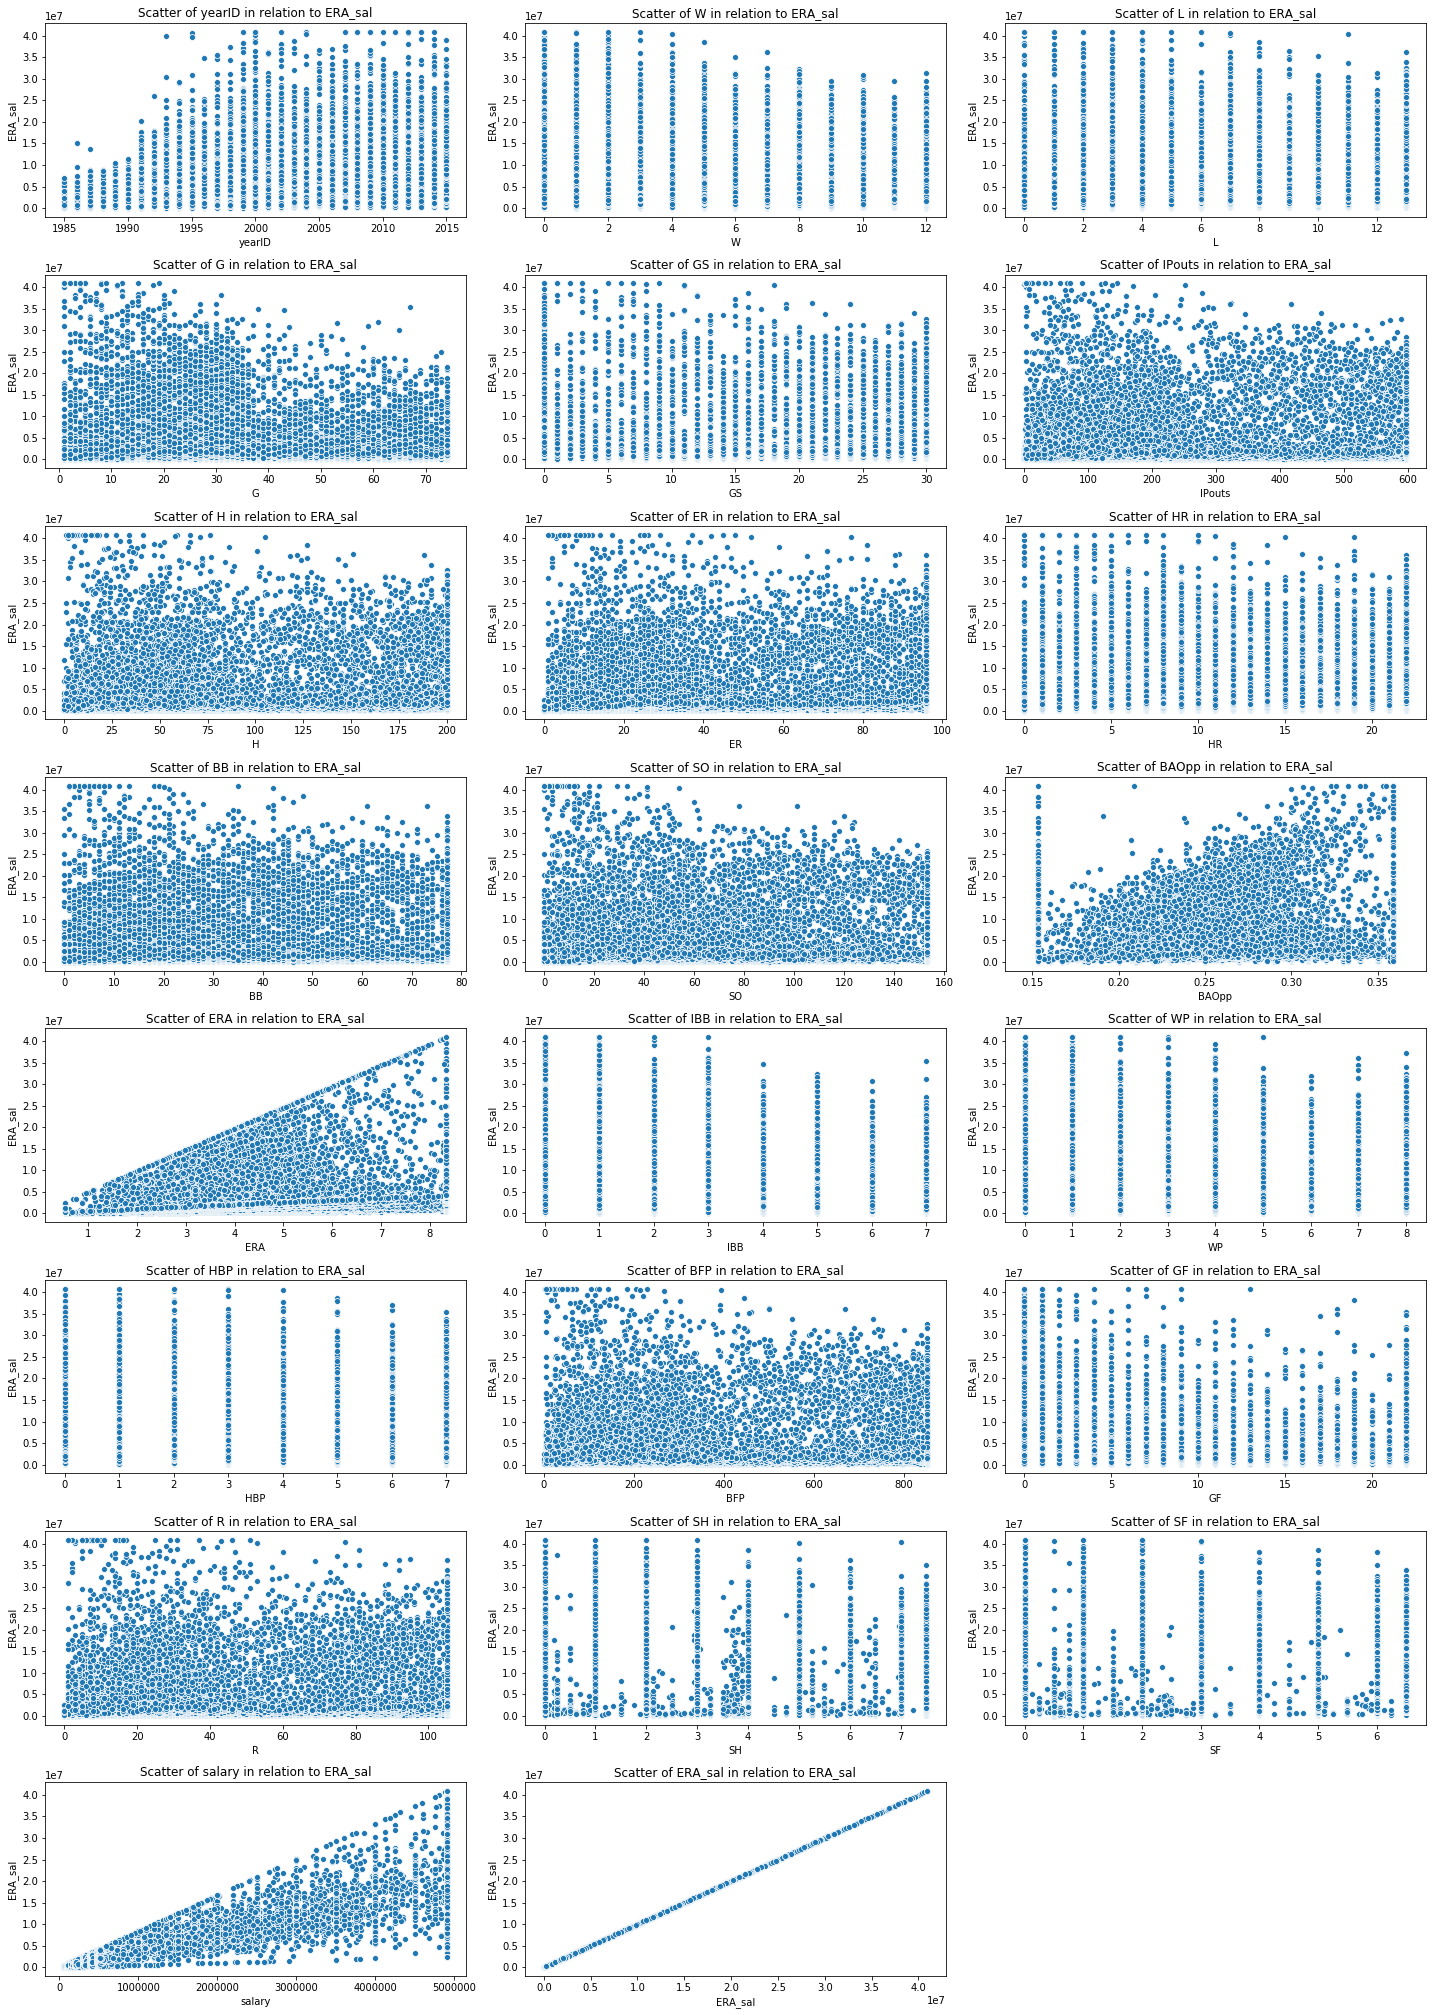

In [60]:
pitching_salary['ERA_sal'] = pitching_salary['ERA'] * pitching_salary['salary']
scatter(pitching_salary, 'ERA_sal', (20,80), 3)

In [61]:
# I will assign X and y values, then check correlation between features
y = pitching_salary['ERA_sal']
X = pitching_salary.drop(['ERA_sal', 'ERA', 'salary', 'playerID', 'teamID_y', 'teamID_x'], axis=1)


In [62]:
# I will be label encoding my 5 ordinal categorical variables

# Categorical list
categorical_cols = list(X.select_dtypes(['category']))
print(categorical_cols) 

# import labelencoder
from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object
le = LabelEncoder()

#transform categorical columns
X[categorical_cols] = X[categorical_cols].apply(lambda col: le.fit_transform(col))

X[categorical_cols].head(10)


['stint', 'CG', 'SHO', 'SV', 'BK']


stint  CG  SHO  SV  BK
0      0   0    0   2   0
1      0   0    0   1   0
2      0   2    1   0   0
3      0   0    0   1   1
4      0   0    0   1   1
5      0   2    1   0   0
6      0   0    0   1   0
7      0   2    1   0   0
8      0   0    0   0   0
9      0   1    1   0   0

In [63]:
X = pd.get_dummies(X, drop_first=True)

ERA_sal    1.000000
salary     0.898523
yearID     0.326849
HR         0.246932
ER         0.246869
GS         0.241771
R          0.237650
L          0.228307
H          0.214021
BFP        0.188234
HBP        0.182584
IPouts     0.180397
SO         0.180018
ERA        0.178723
W          0.154978
BAOpp      0.152604
SF         0.148216
SH         0.144137
BB         0.130228
WP         0.072332
IBB        0.054970
G          0.079831
GF         0.146828
Name: ERA_sal, dtype: float64


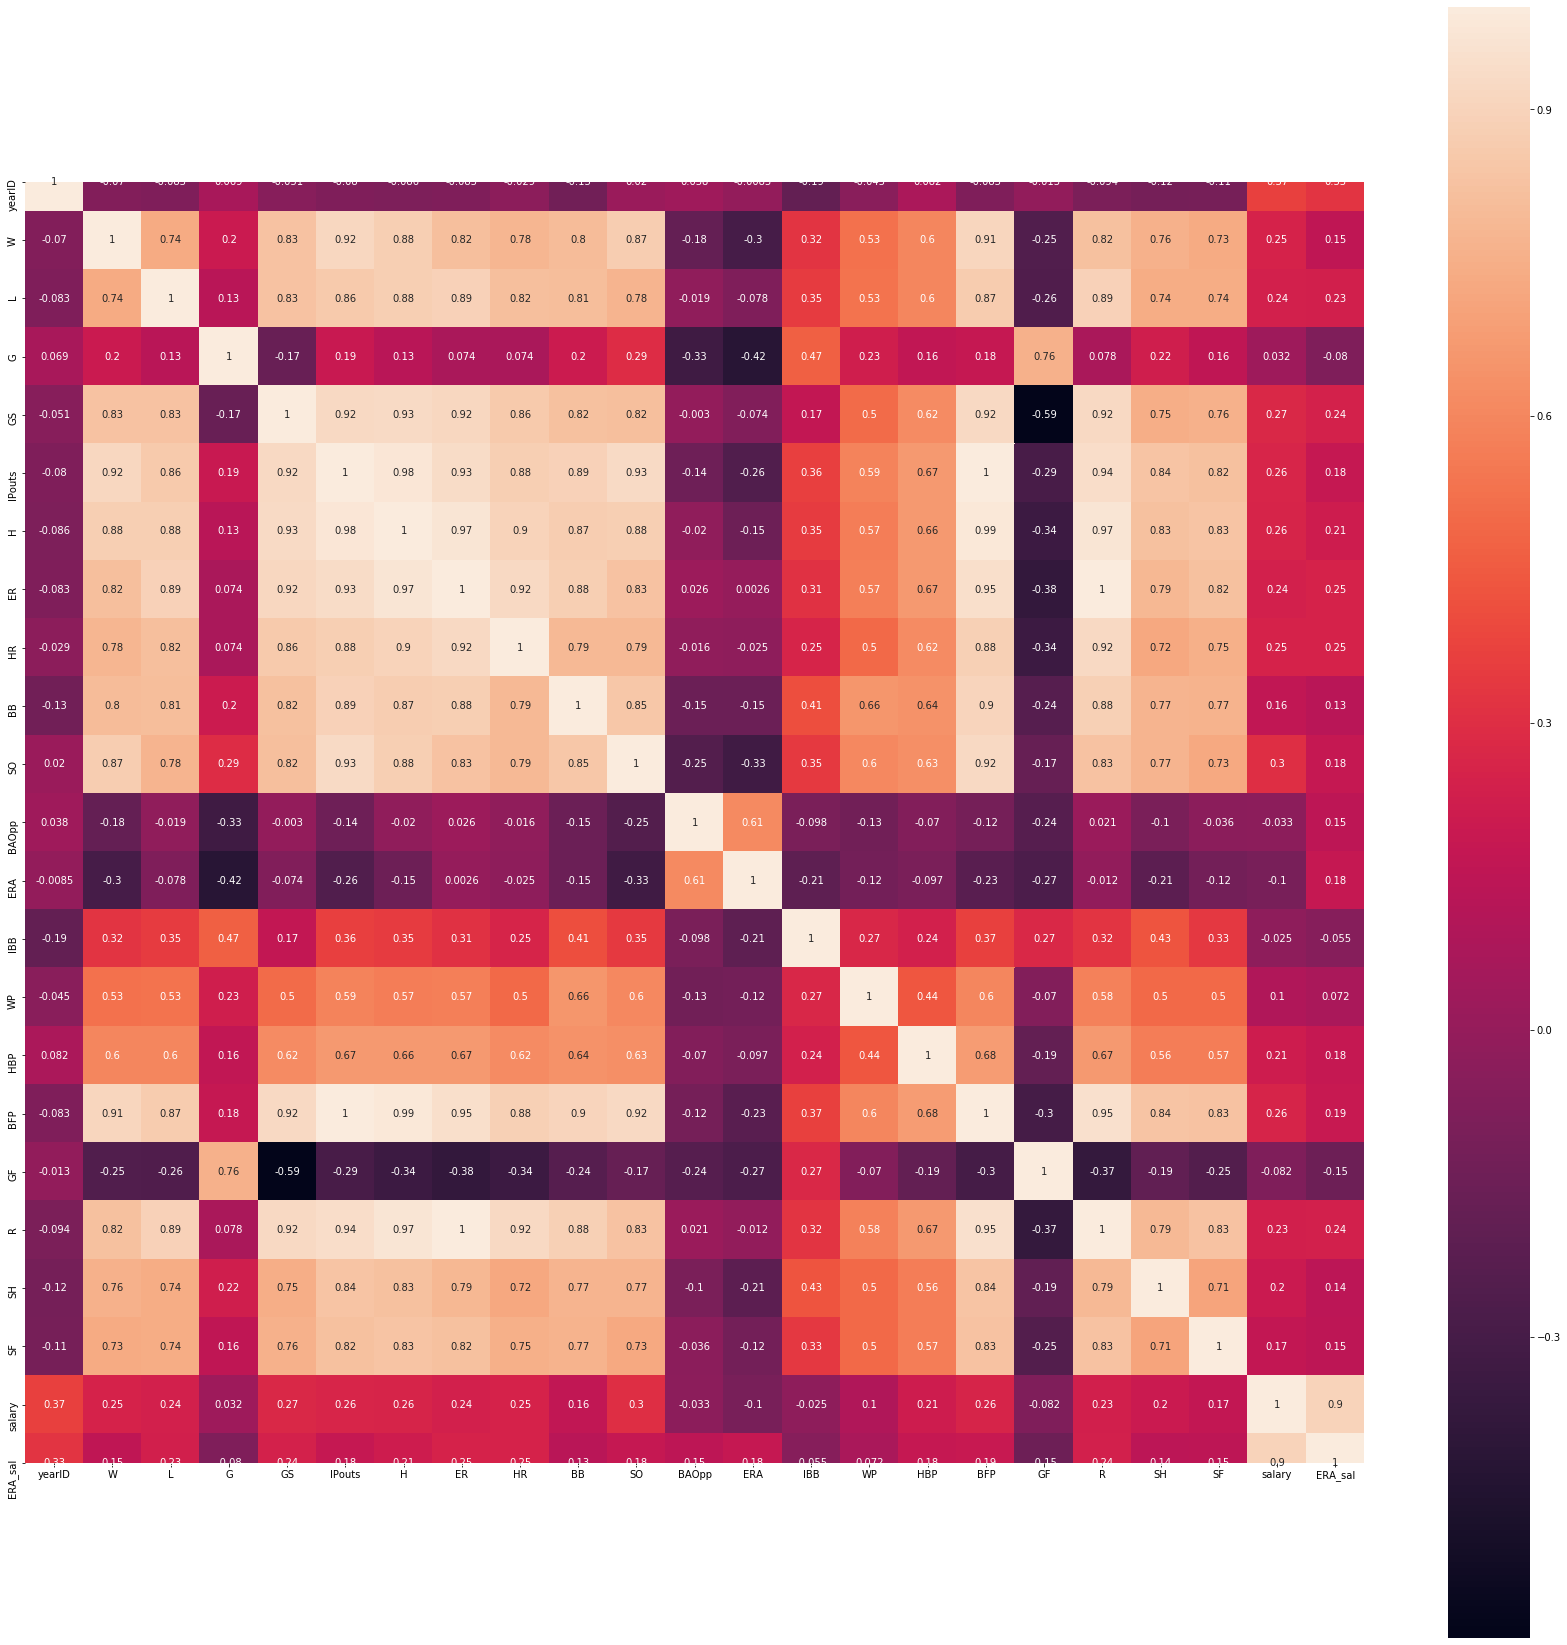

In [64]:
# Let me check correlation now. I may keep lgID and teamID
print(np.abs(pitching_salary.iloc[:, :].corr(
).loc[:, 'ERA_sal'].sort_values(ascending=False))
)

corr = pitching_salary.corr()

plt.figure(figsize=(30,30))

sns.heatmap(corr, square=True, annot=True)

In [65]:
#standardize and normalize my X
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
sc = StandardScaler()
X_std = sc.fit_transform(X)

X_norm = normalize(X_std)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=.25)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
print(rfr.score(X_train, y_train))
print(rfr.score(X_test, y_test))


0.8980941932547434
0.3068514343935267


In [67]:
### Time to start clustering. I'm going to run some programs to see how many clusters is


In [68]:
#KMeans function that takes an x, y, and a number to get a range of clusters
def kmeans_ari_silh(range_num, x, y):
    from sklearn.cluster import KMeans
    for num in range(2, range_num, 1):
        pred = KMeans(n_clusters=num).fit_predict(x)
        labels = KMeans(n_clusters=num).fit_predict(x)
        print("ARI for {} cluster k-means: {}".format(num,
                                                      metrics.adjusted_rand_score(y, pred)))
        print("silhouette for {} cluster k-means: {}".format(num,
                                                      metrics.silhouette_score(x, labels, metric='euclidean')))
        print('='*60)

# Agglomerative Clustering takes a linkage method, affinity, range, x, and y
def agg_ari_silh(linkage, affinity, range_num, x, y):
  from sklearn.cluster import AgglomerativeClustering
  for num in range(2, range_num, 1):
    pred = AgglomerativeClustering(linkage=linkage, 
                                   affinity=affinity,
                                   n_clusters=num).fit_predict(x)
    print("Adjusted Rand Index of the Agglomerative Clustering solution ({}/{}) with {} clusters: {}"
      .format(linkage, affinity, num, metrics.adjusted_rand_score(y, pred)))
    print("The silhoutte score of the Agglomerative Clustering solution ({}/{}) with {} clusters: {}"
      .format(linkage, affinity, num, metrics.silhouette_score(x, pred, metric='euclidean')))
    print('='*90)

# Gaussian Mixture takes in covariance type, range, x, and y
def gmm_ari_silh(covariance_type, range_num, x, y):
  from sklearn.mixture import GaussianMixture  
  for num in range(2, range_num, 1):
    pred = GaussianMixture(n_components=num, covariance_type=covariance_type).fit_predict(x)
    print("ARI score with {} clusters and covariance_type={}: {}".format(num, covariance_type,
      metrics.adjusted_rand_score(y, pred)))

    print("Silhouette score with {} clusters and covariance_type={}: {}".format(num, covariance_type,
      metrics.silhouette_score(x, pred, metric='euclidean')))
    print('='*90)

# DBSCAN takes in eps, min_samples, x, and y 
def dbscan_ari_silh(eps, min_samples, x, y):
  from sklearn.cluster import DBSCAN
  if eps <= min_samples:
    pred = DBSCAN(eps, min_samples).fit_predict(x)
    print("Adjusted Rand Index of the DBSCAN solution with eps {} and min_samples {}: {}"
      .format(eps, min_samples, metrics.adjusted_rand_score(y, pred)))
    print("Silhouette score of the DBSCAN with eps {} and min_samples {}: {}".format(eps, min_samples,
      metrics.silhouette_score(x, pred, metric='euclidean')))
    print('='*90)
  else:
    diff = eps-min_samples
    min_samples = min_samples+diff
    pred = DBSCAN(eps, min_samples).fit_predict(x)
    print("Adjusted Rand Index of the DBSCAN solution with eps {} and min_samples {}: {}"
      .format(eps, min_samples, metrics.adjusted_rand_score(y, pred)))
    print("Silhouette score of the DBSCAN with eps {} and min_samples {}: {}".format(eps, min_samples,
      metrics.silhouette_score(x, pred, metric='euclidean')))
    print('='*90)
    


In [69]:
# check Gaussian Mixture clustering algorithm
types = ['full', 'tied', 'diag', 'spherical']
for i in types:
  gmm_ari_silh(i, 11, X_norm, y)
  print('\n')

ARI score with 2 clusters and covariance_type=full: 7.636595376691007e-05
Silhouette score with 2 clusters and covariance_type=full: 0.31145313754589943
ARI score with 3 clusters and covariance_type=full: 4.834292783358588e-05
Silhouette score with 3 clusters and covariance_type=full: 0.1233413042057488
ARI score with 4 clusters and covariance_type=full: 6.0925667974976035e-05
Silhouette score with 4 clusters and covariance_type=full: 0.11282846001873972
ARI score with 5 clusters and covariance_type=full: 0.00014983543983392315
Silhouette score with 5 clusters and covariance_type=full: 0.11318738455651702
ARI score with 6 clusters and covariance_type=full: 0.00018721980446172867
Silhouette score with 6 clusters and covariance_type=full: 0.09704910207914884
ARI score with 7 clusters and covariance_type=full: 0.00011804785685070666
Silhouette score with 7 clusters and covariance_type=full: 0.07700106663865103
ARI score with 8 clusters and covariance_type=full: 0.00011289096523412662
Silh

Silhouette score with 8 clusters and covariance_type=spherical: 0.0719942518624302
ARI score with 9 clusters and covariance_type=spherical: 0.0003255968648332926
Silhouette score with 9 clusters and covariance_type=spherical: 0.10189610175170673
ARI score with 10 clusters and covariance_type=spherical: 0.0003621806040183651
Silhouette score with 10 clusters and covariance_type=spherical: 0.08037220611508133




In [70]:
# check agglomerative clustering 
agg_ari_silh('ward', 'euclidean', 6, X_std, y)
linkage = ['complete', 'average', 'single']
affinity = ['l1', 'l2', 'manhattan', 'cosine', 'euclidean']
print('\n')
for i in linkage:
  for j in affinity:
    print(i.upper()+'/'+j.upper())
    agg_ari_silh(i, j, 6, X_std, y)
    print('\n')

Adjusted Rand Index of the Agglomerative Clustering solution (ward/euclidean) with 2 clusters: 7.302234087242484e-05
The silhoutte score of the Agglomerative Clustering solution (ward/euclidean) with 2 clusters: 0.3576482863774982
Adjusted Rand Index of the Agglomerative Clustering solution (ward/euclidean) with 3 clusters: 0.00017280036700515765
The silhoutte score of the Agglomerative Clustering solution (ward/euclidean) with 3 clusters: 0.2339867562708527
Adjusted Rand Index of the Agglomerative Clustering solution (ward/euclidean) with 4 clusters: 0.0002121247587905307
The silhoutte score of the Agglomerative Clustering solution (ward/euclidean) with 4 clusters: 0.18611016098116695
Adjusted Rand Index of the Agglomerative Clustering solution (ward/euclidean) with 5 clusters: 0.00020540590336046442
The silhoutte score of the Agglomerative Clustering solution (ward/euclidean) with 5 clusters: 0.19695389254139395


COMPLETE/L1
Adjusted Rand Index of the Agglomerative Clustering soluti

The silhoutte score of the Agglomerative Clustering solution (average/l1) with 3 clusters: 0.1926772014271934
Adjusted Rand Index of the Agglomerative Clustering solution (average/l1) with 4 clusters: 8.679962858972101e-05
The silhoutte score of the Agglomerative Clustering solution (average/l1) with 4 clusters: 0.16833856752407814
Adjusted Rand Index of the Agglomerative Clustering solution (average/l1) with 5 clusters: 8.686732668005674e-05
The silhoutte score of the Agglomerative Clustering solution (average/l1) with 5 clusters: 0.15068933183336775


AVERAGE/L2
Adjusted Rand Index of the Agglomerative Clustering solution (average/l2) with 2 clusters: 4.4173607903043224e-05
The silhoutte score of the Agglomerative Clustering solution (average/l2) with 2 clusters: 0.37699550113124014
Adjusted Rand Index of the Agglomerative Clustering solution (average/l2) with 3 clusters: 4.156685949320018e-05
The silhoutte score of the Agglomerative Clustering solution (average/l2) with 3 clusters: 

Adjusted Rand Index of the Agglomerative Clustering solution (single/l2) with 5 clusters: -4.118235566040378e-06
The silhoutte score of the Agglomerative Clustering solution (single/l2) with 5 clusters: -0.02136723827822142


SINGLE/MANHATTAN
Adjusted Rand Index of the Agglomerative Clustering solution (single/manhattan) with 2 clusters: 3.017432098706653e-08
The silhoutte score of the Agglomerative Clustering solution (single/manhattan) with 2 clusters: 0.13986263729166265
Adjusted Rand Index of the Agglomerative Clustering solution (single/manhattan) with 3 clusters: 6.03560634118543e-08
The silhoutte score of the Agglomerative Clustering solution (single/manhattan) with 3 clusters: 0.0645229379795204
Adjusted Rand Index of the Agglomerative Clustering solution (single/manhattan) with 4 clusters: 9.054522970824577e-08
The silhoutte score of the Agglomerative Clustering solution (single/manhattan) with 4 clusters: 0.038716308366211365
Adjusted Rand Index of the Agglomerative Clusterin

In [71]:
kmeans_ari_silh(11, X_std, y)

ARI for 2 cluster k-means: 6.428671503596883e-05
silhouette for 2 cluster k-means: 0.38442169661623
ARI for 3 cluster k-means: 0.00018248309916781228
silhouette for 3 cluster k-means: 0.2553252509483806
ARI for 4 cluster k-means: 0.0002272455455969754
silhouette for 4 cluster k-means: 0.22472070462485125
ARI for 5 cluster k-means: 0.00022536775754739601
silhouette for 5 cluster k-means: 0.23072655232817132
ARI for 6 cluster k-means: 0.00024129630402609908
silhouette for 6 cluster k-means: 0.21867426402050583
ARI for 7 cluster k-means: 0.0003478041273292976
silhouette for 7 cluster k-means: 0.17173419595969502
ARI for 8 cluster k-means: 0.00041557117929385276
silhouette for 8 cluster k-means: 0.1428211814670248
ARI for 9 cluster k-means: 0.000402648667147862
silhouette for 9 cluster k-means: 0.14147002671383754
ARI for 10 cluster k-means: 0.00041832823928126617
silhouette for 10 cluster k-means: 0.14215144058229445


In [72]:
for i in range(1,4,1):
  for j in range(3,8,1):
    dbscan_ari_silh(i, j, X_std, y)

Adjusted Rand Index of the DBSCAN solution with eps 1 and min_samples 3: -3.630594343739543e-05
Silhouette score of the DBSCAN with eps 1 and min_samples 3: -0.4004744808641972
Adjusted Rand Index of the DBSCAN solution with eps 1 and min_samples 4: -3.5884776591090185e-05
Silhouette score of the DBSCAN with eps 1 and min_samples 4: -0.1971509066066237
Adjusted Rand Index of the DBSCAN solution with eps 1 and min_samples 5: -3.627790995007329e-05
Silhouette score of the DBSCAN with eps 1 and min_samples 5: -0.1250138925758423
Adjusted Rand Index of the DBSCAN solution with eps 1 and min_samples 6: -3.669905620749451e-05
Silhouette score of the DBSCAN with eps 1 and min_samples 6: -0.0814941136168176
Adjusted Rand Index of the DBSCAN solution with eps 1 and min_samples 7: -3.736224248914688e-05
Silhouette score of the DBSCAN with eps 1 and min_samples 7: -0.02234106188072056
Adjusted Rand Index of the DBSCAN solution with eps 2 and min_samples 3: 5.630788963885969e-05
Silhouette score o

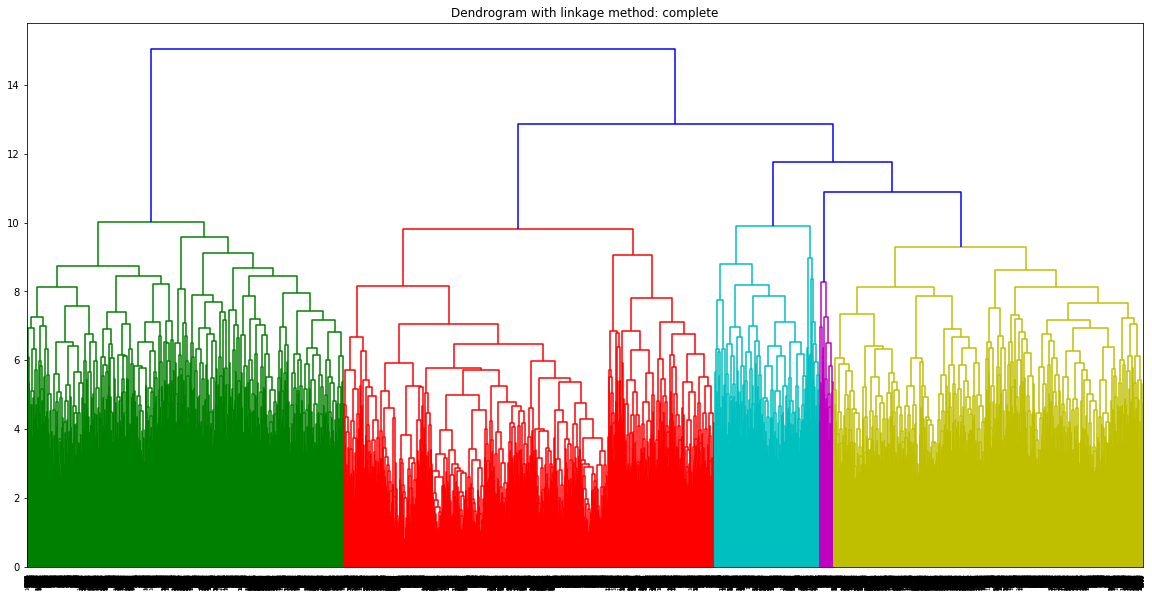

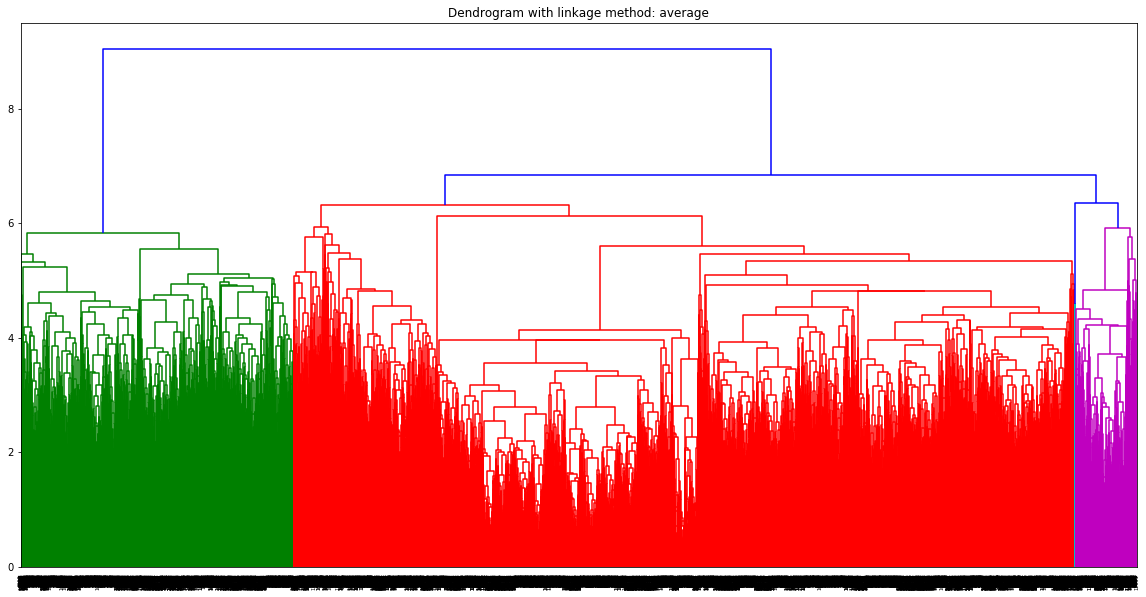

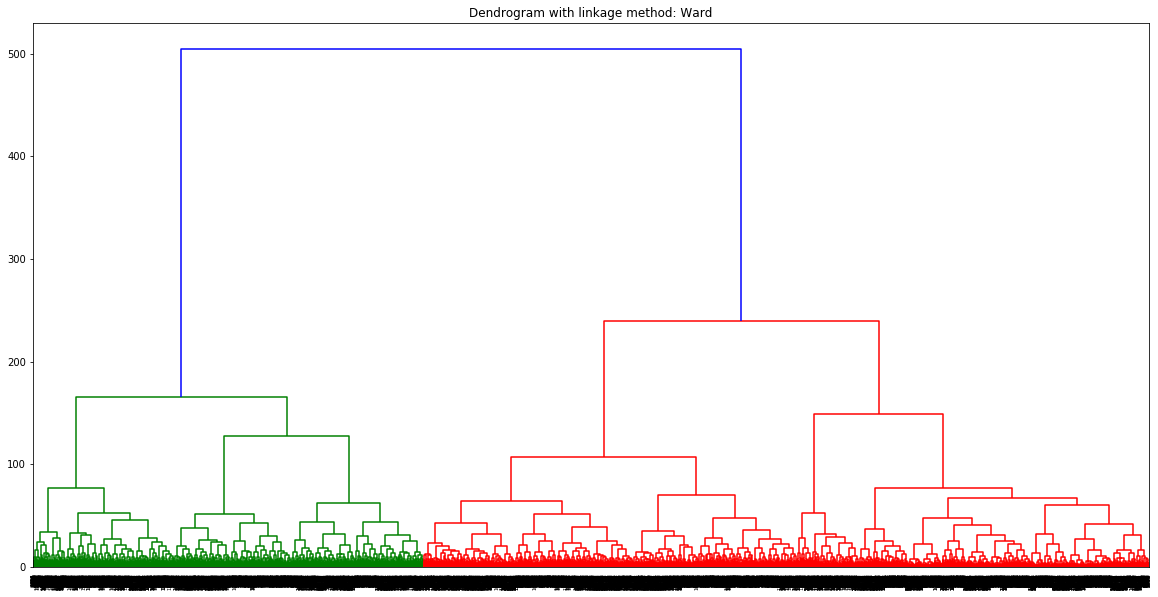

In [73]:
#visualize dendrograms
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize=(20,10))
plt.title("Dendrogram with linkage method: complete")
dendrogram(linkage(X_std, method='complete'))
plt.show()

plt.figure(figsize=(20,10))
plt.title("Dendrogram with linkage method: average")
dendrogram(linkage(X_std, method='average'))
plt.show()

plt.figure(figsize=(20,10))
plt.title("Dendrogram with linkage method: Ward")
dendrogram(linkage(X_std, method='ward'))
plt.show()

### Looking at all of our clustering techniques, it is pretty clear that a two cluster solution is the best. KMeans performs best in regards to silhouette score, but I really can't say that any of them had anything close to approaching a decent ARI.

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 12199 samples in 0.027s...
[t-SNE] Computed neighbors for 12199 samples in 4.459s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12199
[t-SNE] Computed conditional probabilities for sample 2000 / 12199
[t-SNE] Computed conditional probabilities for sample 3000 / 12199
[t-SNE] Computed conditional probabilities for sample 4000 / 12199
[t-SNE] Computed conditional probabilities for sample 5000 / 12199
[t-SNE] Computed conditional probabilities for sample 6000 / 12199
[t-SNE] Computed conditional probabilities for sample 7000 / 12199
[t-SNE] Computed conditional probabilities for sample 8000 / 12199
[t-SNE] Computed conditional probabilities for sample 9000 / 12199
[t-SNE] Computed conditional probabilities for sample 10000 / 12199
[t-SNE] Computed conditional probabilities for sample 11000 / 12199
[t-SNE] Computed conditional probabilities for sample 12000 / 12199
[t-SNE] Computed conditional probabilities for sam

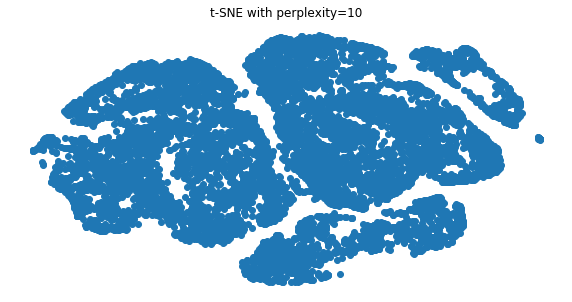

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 12199 samples in 0.027s...
[t-SNE] Computed neighbors for 12199 samples in 5.122s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12199
[t-SNE] Computed conditional probabilities for sample 2000 / 12199
[t-SNE] Computed conditional probabilities for sample 3000 / 12199
[t-SNE] Computed conditional probabilities for sample 4000 / 12199
[t-SNE] Computed conditional probabilities for sample 5000 / 12199
[t-SNE] Computed conditional probabilities for sample 6000 / 12199
[t-SNE] Computed conditional probabilities for sample 7000 / 12199
[t-SNE] Computed conditional probabilities for sample 8000 / 12199
[t-SNE] Computed conditional probabilities for sample 9000 / 12199
[t-SNE] Computed conditional probabilities for sample 10000 / 12199
[t-SNE] Computed conditional probabilities for sample 11000 / 12199
[t-SNE] Computed conditional probabilities for sample 12000 / 12199
[t-SNE] Computed conditional probabilities for sam

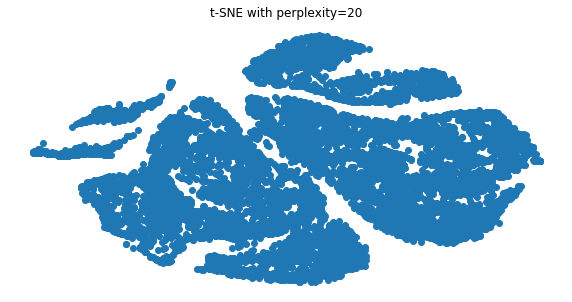

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12199 samples in 0.020s...
[t-SNE] Computed neighbors for 12199 samples in 5.203s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12199
[t-SNE] Computed conditional probabilities for sample 2000 / 12199
[t-SNE] Computed conditional probabilities for sample 3000 / 12199
[t-SNE] Computed conditional probabilities for sample 4000 / 12199
[t-SNE] Computed conditional probabilities for sample 5000 / 12199
[t-SNE] Computed conditional probabilities for sample 6000 / 12199
[t-SNE] Computed conditional probabilities for sample 7000 / 12199
[t-SNE] Computed conditional probabilities for sample 8000 / 12199
[t-SNE] Computed conditional probabilities for sample 9000 / 12199
[t-SNE] Computed conditional probabilities for sample 10000 / 12199
[t-SNE] Computed conditional probabilities for sample 11000 / 12199
[t-SNE] Computed conditional probabilities for sample 12000 / 12199
[t-SNE] Computed conditional probabilities for sam

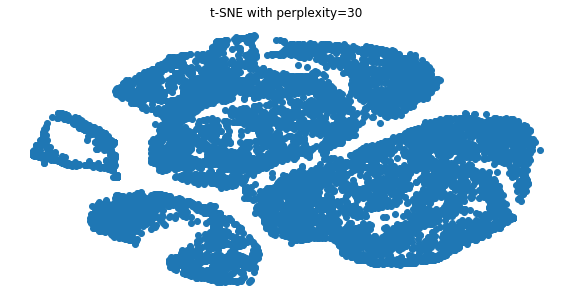

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 12199 samples in 0.030s...
[t-SNE] Computed neighbors for 12199 samples in 5.450s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12199
[t-SNE] Computed conditional probabilities for sample 2000 / 12199
[t-SNE] Computed conditional probabilities for sample 3000 / 12199
[t-SNE] Computed conditional probabilities for sample 4000 / 12199
[t-SNE] Computed conditional probabilities for sample 5000 / 12199
[t-SNE] Computed conditional probabilities for sample 6000 / 12199
[t-SNE] Computed conditional probabilities for sample 7000 / 12199
[t-SNE] Computed conditional probabilities for sample 8000 / 12199
[t-SNE] Computed conditional probabilities for sample 9000 / 12199
[t-SNE] Computed conditional probabilities for sample 10000 / 12199
[t-SNE] Computed conditional probabilities for sample 11000 / 12199
[t-SNE] Computed conditional probabilities for sample 12000 / 12199
[t-SNE] Computed conditional probabilities for sa

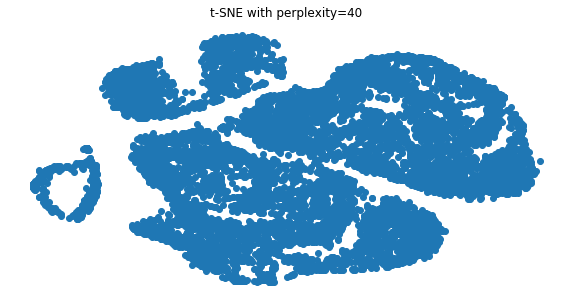

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 12199 samples in 0.028s...
[t-SNE] Computed neighbors for 12199 samples in 5.788s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12199
[t-SNE] Computed conditional probabilities for sample 2000 / 12199
[t-SNE] Computed conditional probabilities for sample 3000 / 12199
[t-SNE] Computed conditional probabilities for sample 4000 / 12199
[t-SNE] Computed conditional probabilities for sample 5000 / 12199
[t-SNE] Computed conditional probabilities for sample 6000 / 12199
[t-SNE] Computed conditional probabilities for sample 7000 / 12199
[t-SNE] Computed conditional probabilities for sample 8000 / 12199
[t-SNE] Computed conditional probabilities for sample 9000 / 12199
[t-SNE] Computed conditional probabilities for sample 10000 / 12199
[t-SNE] Computed conditional probabilities for sample 11000 / 12199
[t-SNE] Computed conditional probabilities for sample 12000 / 12199
[t-SNE] Computed conditional probabilities for sa

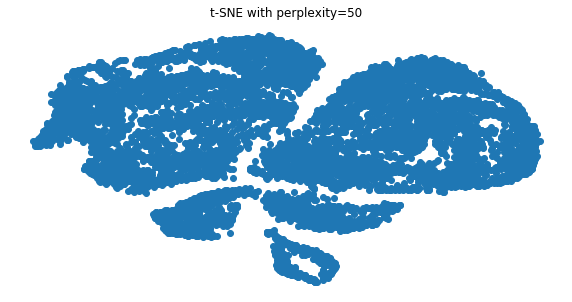

[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 12199 samples in 0.027s...
[t-SNE] Computed neighbors for 12199 samples in 6.019s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12199
[t-SNE] Computed conditional probabilities for sample 2000 / 12199
[t-SNE] Computed conditional probabilities for sample 3000 / 12199
[t-SNE] Computed conditional probabilities for sample 4000 / 12199
[t-SNE] Computed conditional probabilities for sample 5000 / 12199
[t-SNE] Computed conditional probabilities for sample 6000 / 12199
[t-SNE] Computed conditional probabilities for sample 7000 / 12199
[t-SNE] Computed conditional probabilities for sample 8000 / 12199
[t-SNE] Computed conditional probabilities for sample 9000 / 12199
[t-SNE] Computed conditional probabilities for sample 10000 / 12199
[t-SNE] Computed conditional probabilities for sample 11000 / 12199
[t-SNE] Computed conditional probabilities for sample 12000 / 12199
[t-SNE] Computed conditional probabilities for sa

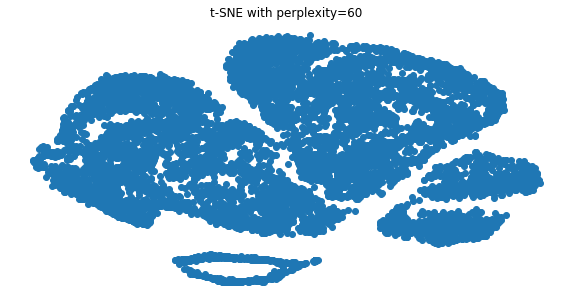

[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 12199 samples in 0.026s...
[t-SNE] Computed neighbors for 12199 samples in 6.253s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12199
[t-SNE] Computed conditional probabilities for sample 2000 / 12199
[t-SNE] Computed conditional probabilities for sample 3000 / 12199
[t-SNE] Computed conditional probabilities for sample 4000 / 12199
[t-SNE] Computed conditional probabilities for sample 5000 / 12199
[t-SNE] Computed conditional probabilities for sample 6000 / 12199
[t-SNE] Computed conditional probabilities for sample 7000 / 12199
[t-SNE] Computed conditional probabilities for sample 8000 / 12199
[t-SNE] Computed conditional probabilities for sample 9000 / 12199
[t-SNE] Computed conditional probabilities for sample 10000 / 12199
[t-SNE] Computed conditional probabilities for sample 11000 / 12199
[t-SNE] Computed conditional probabilities for sample 12000 / 12199
[t-SNE] Computed conditional probabilities for sa

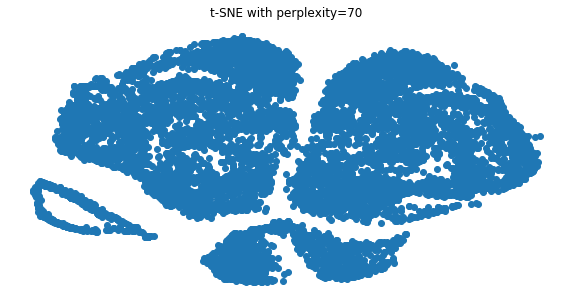

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 12199 samples in 0.028s...
[t-SNE] Computed neighbors for 12199 samples in 7.661s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12199
[t-SNE] Computed conditional probabilities for sample 2000 / 12199
[t-SNE] Computed conditional probabilities for sample 3000 / 12199
[t-SNE] Computed conditional probabilities for sample 4000 / 12199
[t-SNE] Computed conditional probabilities for sample 5000 / 12199
[t-SNE] Computed conditional probabilities for sample 6000 / 12199
[t-SNE] Computed conditional probabilities for sample 7000 / 12199
[t-SNE] Computed conditional probabilities for sample 8000 / 12199
[t-SNE] Computed conditional probabilities for sample 9000 / 12199
[t-SNE] Computed conditional probabilities for sample 10000 / 12199
[t-SNE] Computed conditional probabilities for sample 11000 / 12199
[t-SNE] Computed conditional probabilities for sample 12000 / 12199
[t-SNE] Computed conditional probabilities for sa

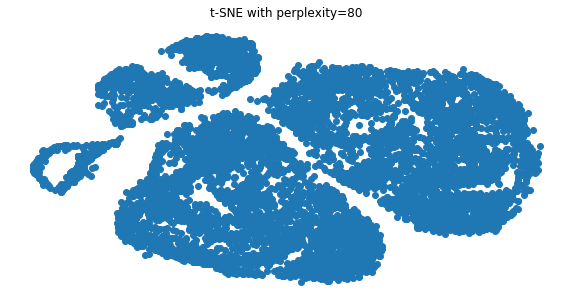

[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 12199 samples in 0.035s...
[t-SNE] Computed neighbors for 12199 samples in 6.574s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12199
[t-SNE] Computed conditional probabilities for sample 2000 / 12199
[t-SNE] Computed conditional probabilities for sample 3000 / 12199
[t-SNE] Computed conditional probabilities for sample 4000 / 12199
[t-SNE] Computed conditional probabilities for sample 5000 / 12199
[t-SNE] Computed conditional probabilities for sample 6000 / 12199
[t-SNE] Computed conditional probabilities for sample 7000 / 12199
[t-SNE] Computed conditional probabilities for sample 8000 / 12199
[t-SNE] Computed conditional probabilities for sample 9000 / 12199
[t-SNE] Computed conditional probabilities for sample 10000 / 12199
[t-SNE] Computed conditional probabilities for sample 11000 / 12199
[t-SNE] Computed conditional probabilities for sample 12000 / 12199
[t-SNE] Computed conditional probabilities for sa

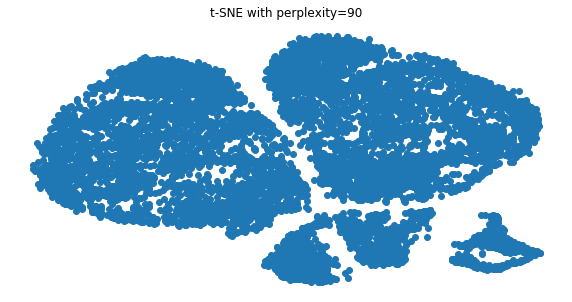

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 12199 samples in 0.027s...
[t-SNE] Computed neighbors for 12199 samples in 7.153s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12199
[t-SNE] Computed conditional probabilities for sample 2000 / 12199
[t-SNE] Computed conditional probabilities for sample 3000 / 12199
[t-SNE] Computed conditional probabilities for sample 4000 / 12199
[t-SNE] Computed conditional probabilities for sample 5000 / 12199
[t-SNE] Computed conditional probabilities for sample 6000 / 12199
[t-SNE] Computed conditional probabilities for sample 7000 / 12199
[t-SNE] Computed conditional probabilities for sample 8000 / 12199
[t-SNE] Computed conditional probabilities for sample 9000 / 12199
[t-SNE] Computed conditional probabilities for sample 10000 / 12199
[t-SNE] Computed conditional probabilities for sample 11000 / 12199
[t-SNE] Computed conditional probabilities for sample 12000 / 12199
[t-SNE] Computed conditional probabilities for sa

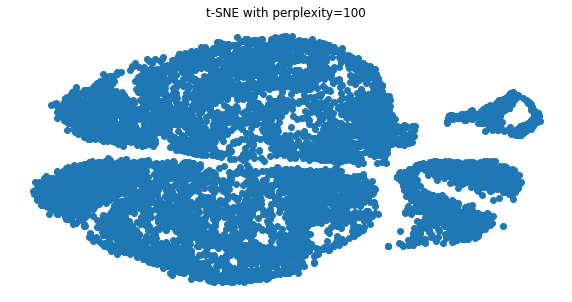

In [74]:
for i in range(10,110,10):
    tsne = TSNE(n_components=2, verbose=1, perplexity=i, n_iter=300)
    tsne_results = tsne.fit_transform(X_norm)
    plt.figure(figsize=(10,5))
    plt.title("t-SNE with perplexity={}".format(i))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()

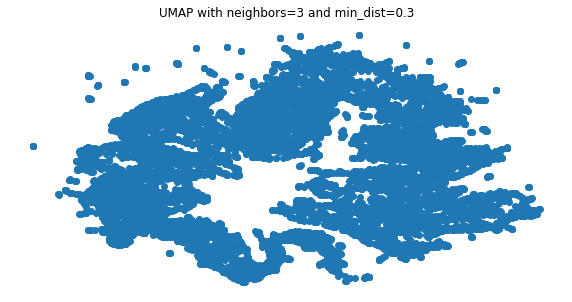

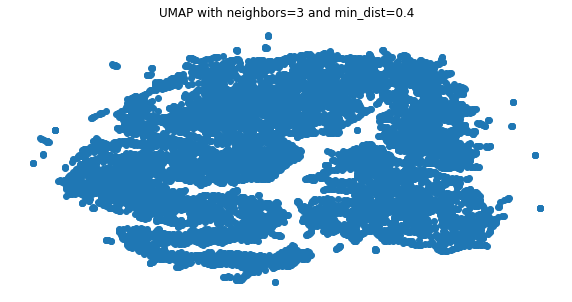

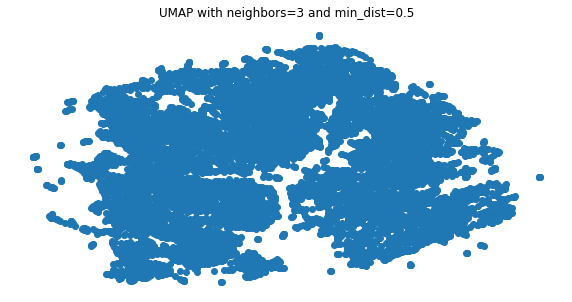

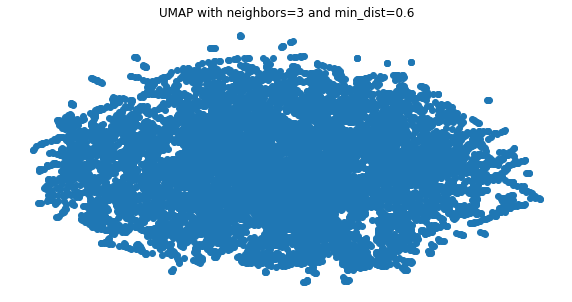

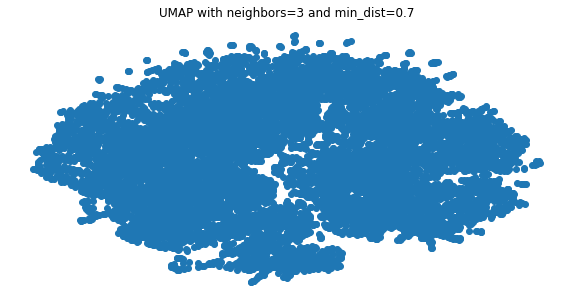

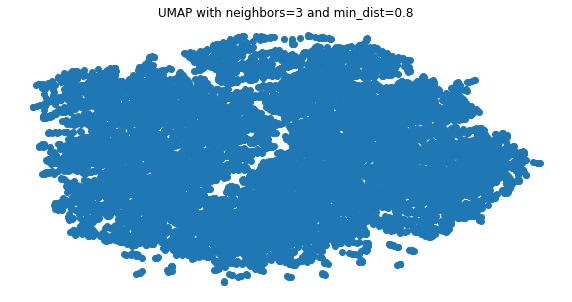

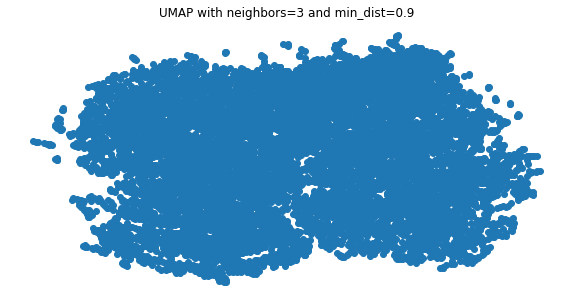

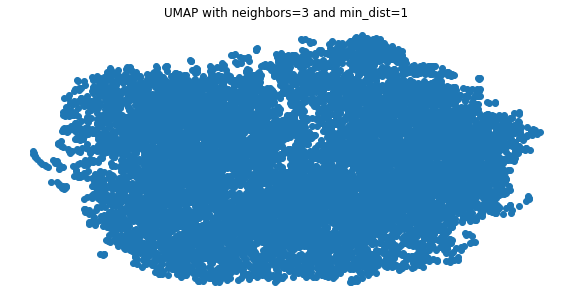

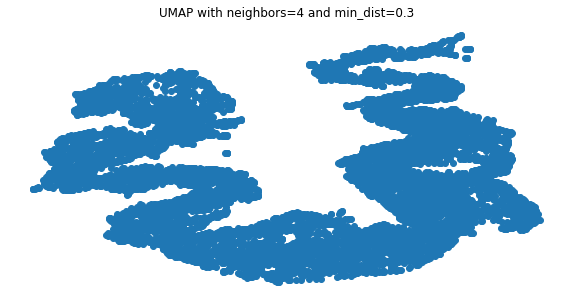

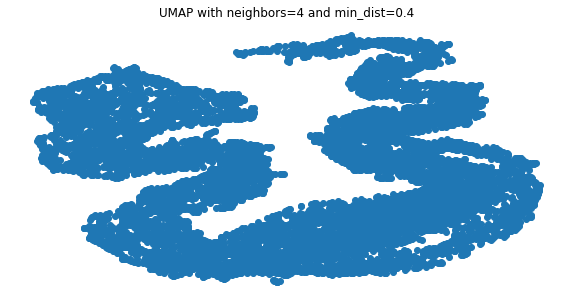

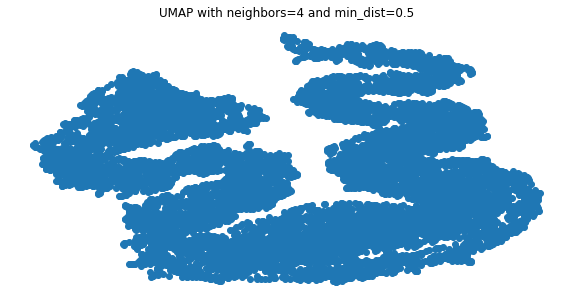

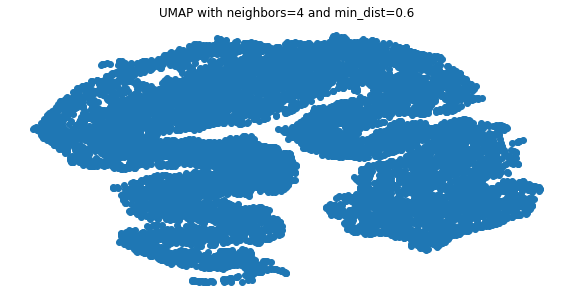

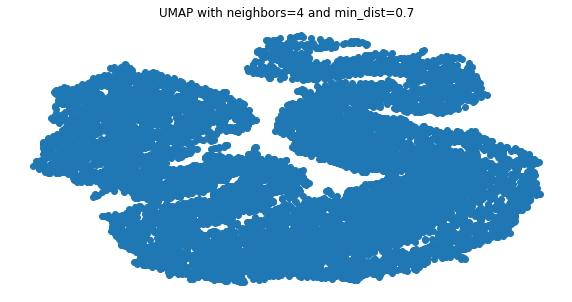

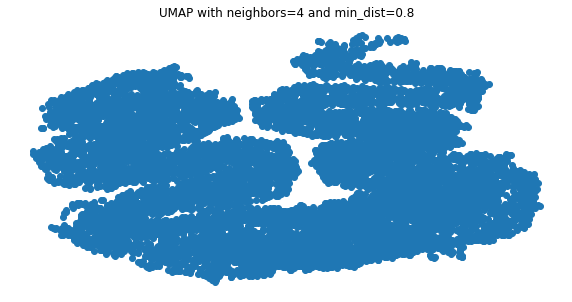

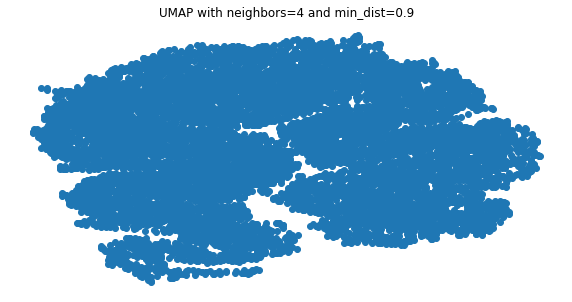

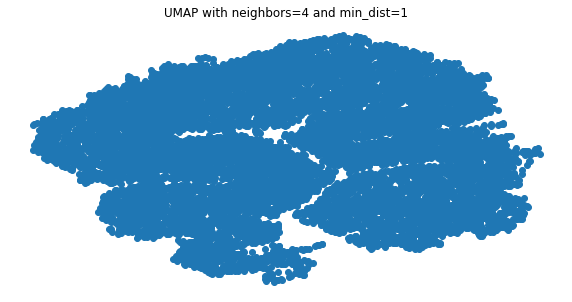

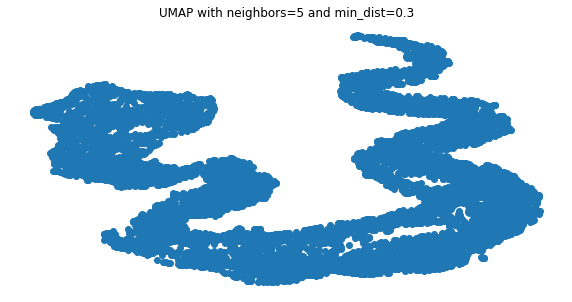

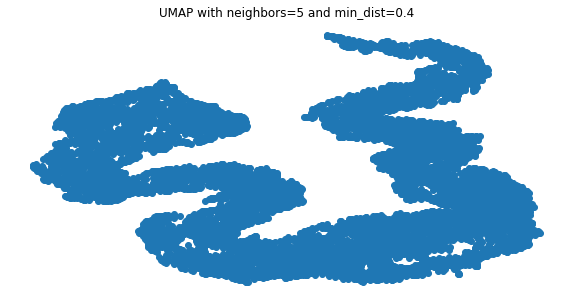

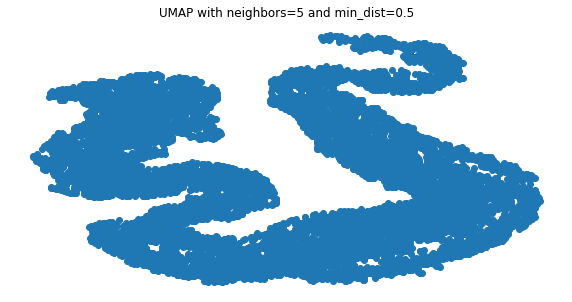

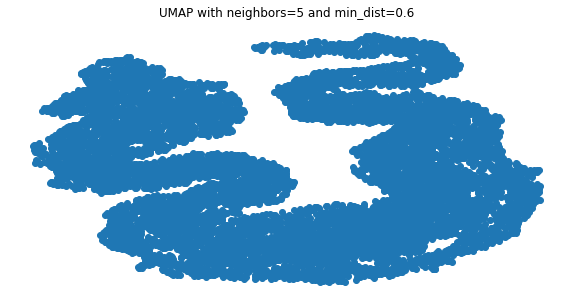

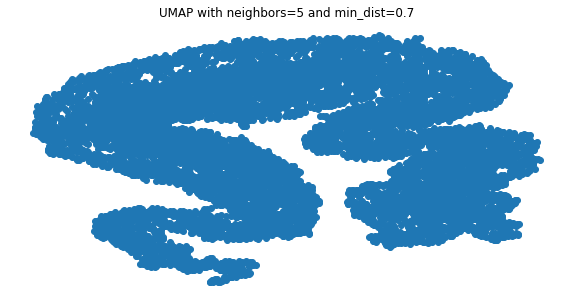

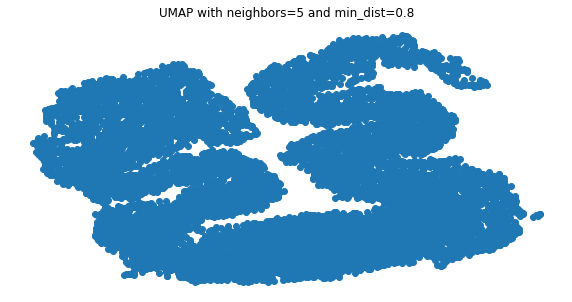

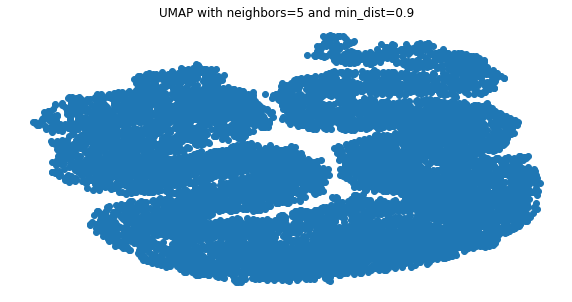

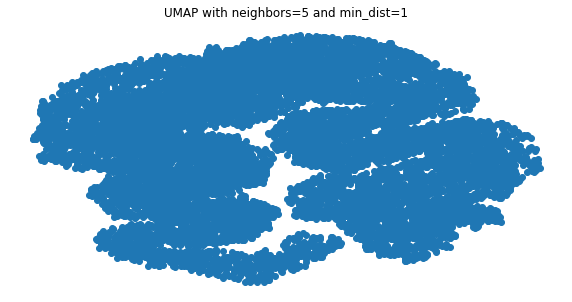

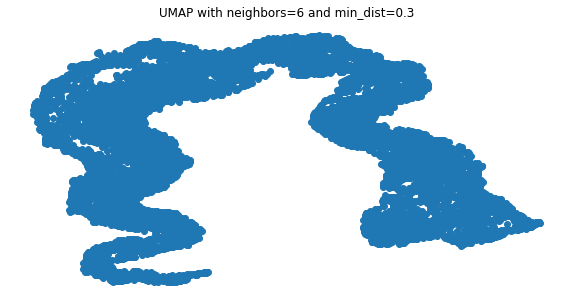

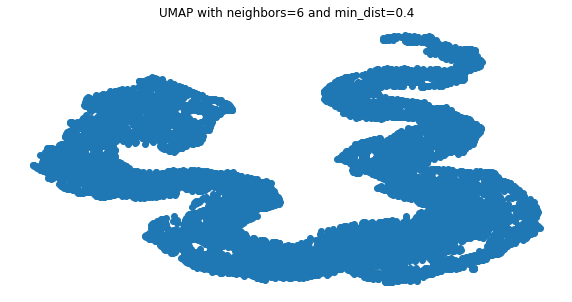

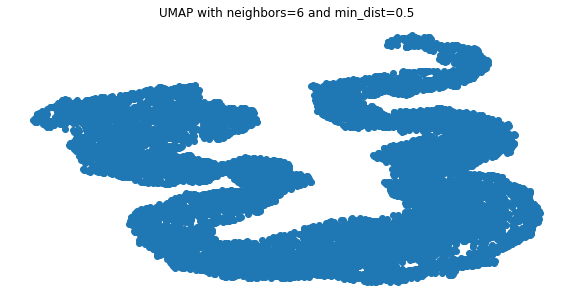

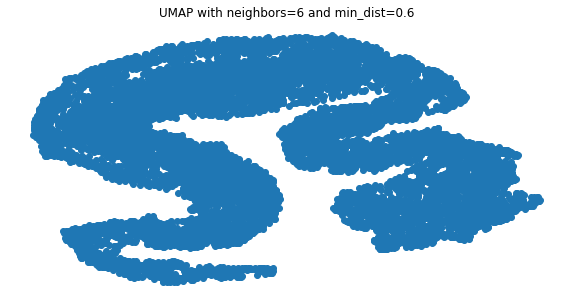

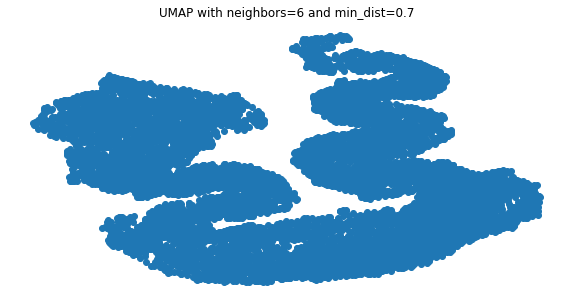

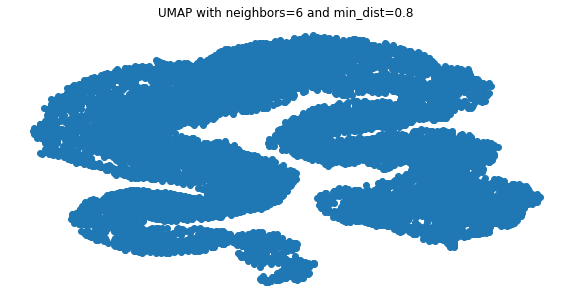

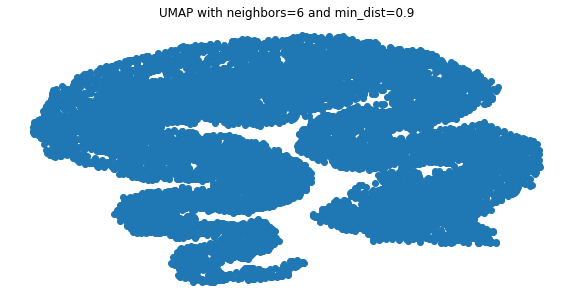

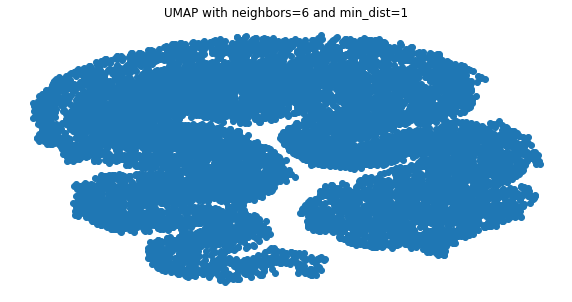

In [75]:
for i in range(3, 7, 1):
    for j in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
        umap_results = umap.UMAP(n_neighbors=i,
                                 min_dist=j,
                                 metric='correlation').fit_transform(X)
        plt.figure(figsize=(10, 5))
        plt.scatter(umap_results[:, 0], umap_results[:, 1])
        plt.title("UMAP with neighbors={} and min_dist={}".format(i,j))
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
        plt.show()

### I don't really need to use dimensionality reduction for this particular problem, but if I did, I would use UMAP with 6 neighbors and a min_distance of 0.3 

In [76]:
# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

### I will now attempt to run a neural network using MLPRegressor

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=.25)



# Import the model.
from sklearn.neural_network import MLPRegressor

# Start by checking the layer size hyperparameter
for tup in [(100), (100,100), (100,100,100), (100,100,100,100), (100,100,100,100,100)]:
    mlpr = MLPRegressor(hidden_layer_sizes=(tup))
    mlpr.fit(X_train, y_train)
    print('='*40)
    print('hidden layers:{}'.format(tup))
    print('Training score:{}'.format(mlpr.score(X_train, y_train)))
    print('Test score:{}'.format(mlpr.score(X_test, y_test)))
    print('='*40,'\n')


hidden layers:100
Training score:-0.658668985504065
Test score:-0.6134508759027422

hidden layers:(100, 100)
Training score:0.13659006620905667
Test score:0.13270584077353365

hidden layers:(100, 100, 100)
Training score:0.2633427145819759
Test score:0.2438149102130428

hidden layers:(100, 100, 100, 100)
Training score:0.29703498587321975
Test score:0.26670999360915415

hidden layers:(100, 100, 100, 100, 100)
Training score:0.34273250815830736
Test score:0.28440832977099395



In [78]:
activation = ['identity', 'logistic','tanh', 'relu']
solver = ['lbfgs', 'adam']
learning_rate = ['constant', 'invscaling', 'adaptive']
for a in activation:
    for s in solver:
        for l in learning_rate:
            mlpr = MLPRegressor(hidden_layer_sizes=(100,100,100,100), 
                                activation=a, 
                                solver=s, 
                                learning_rate=l)
            mlpr.fit(X_train, y_train)
            print('\n')
            print('Activation:{}\nSolver:{}\nLearning Rate:{}\nTraining:{}\nTest:{}'.format(
            a, s, l, mlpr.score(X_train, y_train), mlpr.score(X_test, y_test)))
            print('='*50)



Activation:identity
Solver:lbfgs
Learning Rate:constant
Training:0.24125179238966377
Test:0.22183366269553392


Activation:identity
Solver:lbfgs
Learning Rate:invscaling
Training:0.03165258714747454
Test:0.02860144313148094


Activation:identity
Solver:lbfgs
Learning Rate:adaptive
Training:0.24284051992634792
Test:0.22360702345705474


Activation:identity
Solver:adam
Learning Rate:constant
Training:0.2412165565065526
Test:0.22081700485260647


Activation:identity
Solver:adam
Learning Rate:invscaling
Training:0.24140198466812868
Test:0.2210140461440998


Activation:identity
Solver:adam
Learning Rate:adaptive
Training:0.24071415189546652
Test:0.22091352621676272


Activation:logistic
Solver:lbfgs
Learning Rate:constant
Training:0.0
Test:-0.0009972233521915452


Activation:logistic
Solver:lbfgs
Learning Rate:invscaling
Training:0.0
Test:-0.0009972234532971136


Activation:logistic
Solver:lbfgs
Learning Rate:adaptive
Training:-2.220446049250313e-16
Test:-0.0009972234554225246


Activatio

In [79]:
# It looks to me that activation set to relu and 
# solver set to adam yields the best results
# I will start with tweaking learning_rate_init
for r in [0.001,0.002,0.003,0.005,0.01]:
    mlpr = MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.99, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100, 100, 100, 100), learning_rate='constant',
             learning_rate_init=r, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)
                    
    mlpr.fit(X_train, y_train)
    print('learning rate init:{}'.format(r))
    print(mlpr.score(X_train,y_train))
    print(mlpr.score(X_test, y_test))
    print('\n','='*40)

learning rate init:0.001
0.296327274050898
0.2676947190550115

learning rate init:0.002
0.32348449227092024
0.28142190406056733

learning rate init:0.003
0.36084946108269733
0.2800243889342239

learning rate init:0.005
0.4646340325767192
0.23547977724750302

learning rate init:0.01
0.589861606163362
0.04063387291687537



### The original initial learning rate of 0.001 seems best. The higher I go the better my performance on the training set, but I'm certainly overfitting.

In [80]:
# as initial learning rate goes up, overfitting also increases
for i in [200,300,400,500,1000]:   
    mlpr = MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.99, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100, 100, 100, 100), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=i,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)
                    
    mlpr.fit(X_train, y_train)
    print('max_iter:{}'.format(i))
    print(mlpr.score(X_train,y_train))
    print(mlpr.score(X_test, y_test))
    print('\n','='*40)

max_iter:200
0.2957055103220898
0.2683352227061576

max_iter:300
0.3125139911505288
0.2754584157063954

max_iter:400
0.32723645943398655
0.28365404280900297

max_iter:500
0.3443399342801675
0.28547201729720184

max_iter:1000
0.4810857098211789
0.23061722664317608



In [81]:
# the last hyper-parameter I want to test is the warm start parameter. 
# I will set it to True
mlpr = MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.99, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100, 100, 100, 100), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=True,
             warm_start=True)
mlpr.fit(X_train, y_train)
print(mlpr.score(X_train, y_train))
print(mlpr.score(X_test, y_test))

Iteration 1, loss = 45716080596465.56250000
Iteration 2, loss = 45712497137740.35937500
Iteration 3, loss = 45662964113007.71875000
Iteration 4, loss = 45382273507292.41406250
Iteration 5, loss = 44437503442480.25000000
Iteration 6, loss = 42204037150245.82031250
Iteration 7, loss = 38232176355524.28906250
Iteration 8, loss = 32885954769913.06640625
Iteration 9, loss = 27901979532253.02734375
Iteration 10, loss = 25328689827471.14062500
Iteration 11, loss = 24665985488915.77734375
Iteration 12, loss = 24369709552252.20312500
Iteration 13, loss = 24097206672075.78515625
Iteration 14, loss = 23843761903925.01562500
Iteration 15, loss = 23601330114550.36718750
Iteration 16, loss = 23361645909275.10546875
Iteration 17, loss = 23124755436840.81250000
Iteration 18, loss = 22909840510575.85546875
Iteration 19, loss = 22706621215796.32812500
Iteration 20, loss = 22513269982551.42578125
Iteration 21, loss = 22354590570099.14453125
Iteration 22, loss = 22179311056240.46484375
Iteration 23, loss 

Iteration 183, loss = 19475115955935.87109375
Iteration 184, loss = 19467010118284.05859375
Iteration 185, loss = 19449881554764.94921875
Iteration 186, loss = 19443576448885.83984375
Iteration 187, loss = 19445789546705.05468750
Iteration 188, loss = 19436776876420.26953125
Iteration 189, loss = 19428305526273.94140625
Iteration 190, loss = 19428234367509.47656250
Iteration 191, loss = 19412802512354.77343750
Iteration 192, loss = 19412067570891.50390625
Iteration 193, loss = 19411585958312.35937500
Iteration 194, loss = 19405857693336.69921875
Iteration 195, loss = 19399514170646.04296875
Iteration 196, loss = 19394674659301.00000000
Iteration 197, loss = 19390627053880.77734375
Iteration 198, loss = 19398327565771.09375000
Iteration 199, loss = 19387329571042.23437500
Iteration 200, loss = 19379381539224.39843750
0.2960042188010553
0.26769018611180306


### So it looks like no matter how I cut it, I'm only get an R-squared value of a little under .30.  I basically got the same results using random forest. It's also interesting that the default settings seem to give me the best and most consistent results. Using MLP certainly eliminated my overfitting problems that I had with Random Forest

### I will now check to see if I can get better results in determining salary.

In [82]:
pitching_salary.columns


Index(['playerID', 'yearID', 'stint', 'teamID_x', 'lgID', 'W', 'L', 'G', 'GS',
       'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp',
       'ERA', 'IBB', 'WP', 'HBP', 'BK', 'BFP', 'GF', 'R', 'SH', 'SF',
       'teamID_y', 'salary', 'ERA_sal'],
      dtype='object')

In [83]:
X = pitching_salary.drop(['playerID', 'teamID_x','teamID_y', 'salary'], axis=1)
y = pitching_salary['salary']

# import labelencoder
from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object
le = LabelEncoder()

#transform categorical columns
X[categorical_cols] = X[categorical_cols].apply(lambda col: le.fit_transform(col))

X = pd.get_dummies(X, drop_first=True)

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

X_norm = normalize(X_std)

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=.25)

In [84]:
# run random forest for baseline 
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

print(rfr.score(X_train, y_train))
print(rfr.score(X_test, y_test))

0.9988657600770537
0.9923529598212698


In [85]:
# Establish and fit the model
for tup in [(100), (100,100), (100,100,100), (100,100,100,100)]:
    mlpr = MLPRegressor(hidden_layer_sizes=(tup))
    mlpr.fit(X_train, y_train)
    print('='*40)
    print('hidden layers:{}'.format(tup))
    print('Training score:{}'.format(mlpr.score(X_train, y_train)))
    print('Test score:{}'.format(mlpr.score(X_test, y_test)))
    print('='*40,'\n')

hidden layers:100
Training score:-0.7376877677337608
Test score:-0.761121895344071

hidden layers:(100, 100)
Training score:0.700140814958542
Test score:0.7198601433272553

hidden layers:(100, 100, 100)
Training score:0.9605163971095191
Test score:0.9596060447298163

hidden layers:(100, 100, 100, 100)
Training score:0.9925289804017725
Test score:0.9887160346033337



In [86]:
# check agglomerative clustering 
agg_ari_silh('ward', 'euclidean', 6, X_norm, y)
linkage = ['complete', 'average', 'single']
affinity = ['manhattan', 'cosine', 'euclidean']
print('\n')
for i in linkage:
  for j in affinity:
    print(i.upper()+'/'+j.upper())
    agg_ari_silh(i, j, 6, X_std, y)
    print('\n')

Adjusted Rand Index of the Agglomerative Clustering solution (ward/euclidean) with 2 clusters: 0.0009386667600815075
The silhoutte score of the Agglomerative Clustering solution (ward/euclidean) with 2 clusters: 0.30212527294480956
Adjusted Rand Index of the Agglomerative Clustering solution (ward/euclidean) with 3 clusters: 0.011082200108559854
The silhoutte score of the Agglomerative Clustering solution (ward/euclidean) with 3 clusters: 0.25561715779817124
Adjusted Rand Index of the Agglomerative Clustering solution (ward/euclidean) with 4 clusters: 0.013201218052077251
The silhoutte score of the Agglomerative Clustering solution (ward/euclidean) with 4 clusters: 0.24001073059468422
Adjusted Rand Index of the Agglomerative Clustering solution (ward/euclidean) with 5 clusters: 0.004090063282684184
The silhoutte score of the Agglomerative Clustering solution (ward/euclidean) with 5 clusters: 0.15548503565701371


COMPLETE/MANHATTAN
Adjusted Rand Index of the Agglomerative Clustering so

Adjusted Rand Index of the Agglomerative Clustering solution (average/euclidean) with 3 clusters: -0.003480232520891577
The silhoutte score of the Agglomerative Clustering solution (average/euclidean) with 3 clusters: 0.2354010812019478
Adjusted Rand Index of the Agglomerative Clustering solution (average/euclidean) with 4 clusters: -0.0034771334726308644
The silhoutte score of the Agglomerative Clustering solution (average/euclidean) with 4 clusters: 0.2122613627967776
Adjusted Rand Index of the Agglomerative Clustering solution (average/euclidean) with 5 clusters: -0.003092730238160539
The silhoutte score of the Agglomerative Clustering solution (average/euclidean) with 5 clusters: 0.15812949357260303


SINGLE/MANHATTAN
Adjusted Rand Index of the Agglomerative Clustering solution (single/manhattan) with 2 clusters: -3.0245862023094527e-05
The silhoutte score of the Agglomerative Clustering solution (single/manhattan) with 2 clusters: 0.03845812761117599
Adjusted Rand Index of the Agg

In [87]:
kmeans_ari_silh(11, X_norm, y)

ARI for 2 cluster k-means: 0.000776599425506534
silhouette for 2 cluster k-means: 0.3134266400715254
ARI for 3 cluster k-means: 0.009941516397490802
silhouette for 3 cluster k-means: 0.28091112802949875
ARI for 4 cluster k-means: 0.015108479345669003
silhouette for 4 cluster k-means: 0.22645935012703944
ARI for 5 cluster k-means: 0.006194884312843263
silhouette for 5 cluster k-means: 0.14220642080460813
ARI for 6 cluster k-means: 0.023809226201640665
silhouette for 6 cluster k-means: 0.21055184567720855
ARI for 7 cluster k-means: 0.014367817577293806
silhouette for 7 cluster k-means: 0.13852324687592088
ARI for 8 cluster k-means: 0.011564611690284379
silhouette for 8 cluster k-means: 0.1338056829855654
ARI for 9 cluster k-means: 0.01667909943301721
silhouette for 9 cluster k-means: 0.13426354627075104
ARI for 10 cluster k-means: 0.02329471516185796
silhouette for 10 cluster k-means: 0.13712500001259254


### I want to run the same models on just the pitching df with ERA as the target variable

In [88]:
print(pitching.columns)

Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'W', 'L', 'G', 'GS',
       'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp',
       'ERA', 'IBB', 'WP', 'HBP', 'BK', 'BFP', 'GF', 'R', 'SH', 'SF'],
      dtype='object')


In [89]:
y = pitching['ERA']
X = pitching.drop(['playerID', 'teamID', 'ERA'], axis=1)

# import labelencoder
from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object
le = LabelEncoder()

#transform categorical columns
X[categorical_cols] = X[categorical_cols].apply(lambda col: le.fit_transform(col))

X = pd.get_dummies(X, drop_first=True)

In [90]:
#standardize and normalize my X
sc = StandardScaler()
X_std = sc.fit_transform(X)

X_norm = normalize(X_std)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=.25)

In [91]:
# run random forest for baseline
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

print(rfr.score(X_train, y_train))
print(rfr.score(X_test, y_test))

0.9907918807128548
0.9340923226335209


In [92]:
# Establish and fit the model
for tup in [(100), (100,100), (100,100,100), (100,100,100,100)]:
    mlpr = MLPRegressor(hidden_layer_sizes=(tup))
    mlpr.fit(X_train, y_train)
    print('='*40)
    print('hidden layers:{}'.format(tup))
    print('Training score:{}'.format(mlpr.score(X_train, y_train)))
    print('Test score:{}'.format(mlpr.score(X_test, y_test)))
    print('='*40,'\n')

hidden layers:100
Training score:0.8892149309219626
Test score:0.8860817099546878

hidden layers:(100, 100)
Training score:0.9726482243409901
Test score:0.959265852119653

hidden layers:(100, 100, 100)
Training score:0.920755469749559
Test score:0.9119493905798813

hidden layers:(100, 100, 100, 100)
Training score:0.9686481095664097
Test score:0.9560414953371327



### So random forest did better on the training set, but I think that the MLP regressor really captured the underlying pattern.

### Now I'll run the MLPClassifier to see if we can guess a complete game with shutout

In [93]:
categorical_cols.remove('SHO')
print(categorical_cols)

['stint', 'CG', 'SV', 'BK']


In [94]:
y = pitching['SHO']
X = pitching.drop(['playerID', 'teamID', 'SHO'], axis=1)

# instantiate labelencoder object
le = LabelEncoder()

#transform categorical columns
X[categorical_cols] = X[categorical_cols].apply(lambda col: le.fit_transform(col))

X = pd.get_dummies(X, drop_first=True)

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

X_norm = normalize(X_std)

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=.25)

In [95]:
from sklearn.neural_network import MLPClassifier
# Establish and fit the model
for tup in [(100), (100,100), (100,100,100), (100,100,100,100)]:
    mlpc = MLPClassifier(hidden_layer_sizes=(tup))
    mlpc.fit(X_train, y_train)
    print('='*40)
    print('hidden layers:{}'.format(tup))
    print('Training score:{}'.format(mlpc.score(X_train, y_train)))
    print('Test score:{}'.format(mlpc.score(X_test, y_test)))
    print('='*40,'\n')

hidden layers:100
Training score:0.9569907439626975
Test score:0.9394572025052192

hidden layers:(100, 100)
Training score:0.9857331755863317
Test score:0.9338204592901879

hidden layers:(100, 100, 100)
Training score:0.988934511796228
Test score:0.9346555323590814

hidden layers:(100, 100, 100, 100)
Training score:0.9958243440740483
Test score:0.9346555323590814



# Conclusion

### There are a lot of take-aways here. 
* This particular dataset doesn't cluster well. It could be the data itself or maybe my target. I don't rightly know.
* My true target at the outset of this was to try and predict a player's worth in regards to his ERA. I did spectacularly poorly at that. I find it interesting. I would've thought that given the information at hand that I would have a better performing model. My only thought is that somehow ERA and salary have such low correlation with each other that it made it hard for my model to predict. It's another question that will be plaguing me for the days to come.
* Using a neural network was able to overcome the overfitting problems I had while using Random Forest for a baseline measurement. It leads me to believe that it did pick up the underlying patterns associated with the information that was fed into it.
* I would like to revisit this problem at some point. Maybe some other combination of salary and ERA would make sense to be able to get a better predictive model.
* This is just scratching the surface of what could be done with unsupervised learning and this baseball dataset. Some other files that would be interesting to explore would be fielding, batting, and hall of fame players. I could combine all of those datasets to determine whether a player will be inducted into the hall of fame. 